In [1]:
%matplotlib inline

# Transit fitting

In [2]:
%run notebook_setup

theano version: 1.0.4


pymc3 version: 3.6


exoplanet version: 0.2.0


*exoplanet* includes methods for computing the light curves transiting planets.
In its simplest form this can be used to evaluate a light curve like you would do with [batman](https://astro.uchicago.edu/~kreidberg/batman/), for example:

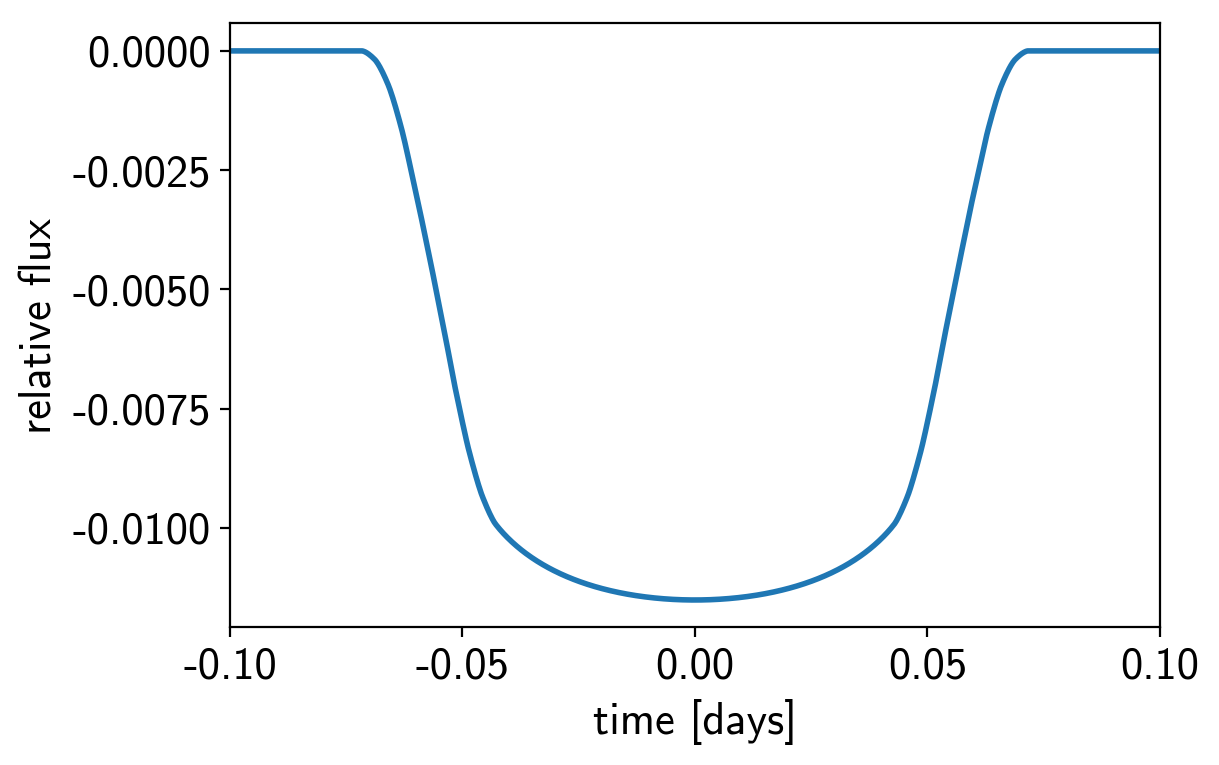

In [3]:
import numpy as np
import matplotlib.pyplot as plt

import exoplanet as xo

# The light curve calculation requires an orbit
orbit = xo.orbits.KeplerianOrbit(period=3.456)

# Compute a limb-darkened light curve using starry
t = np.linspace(-0.1, 0.1, 1000)
u = [0.3, 0.2]
light_curve = xo.StarryLightCurve(u).get_light_curve(
    orbit=orbit, r=0.1, t=t, texp=0.02).eval()
# Note: the `eval` is needed because this is using Theano in
# the background

plt.plot(t, light_curve, color="C0", lw=2)
plt.ylabel("relative flux")
plt.xlabel("time [days]")
plt.xlim(t.min(), t.max());

But the real power comes from the fact that this is defined as a [Theano operation](http://deeplearning.net/software/theano/extending/extending_theano.html) so it can be combined with PyMC3 to do transit inference using Hamiltonian Monte Carlo.

## The transit model in PyMC3

In this section, we will construct a simple transit fit model using *PyMC3* and then we will fit a two planet model to simulated data.
To start, let's randomly sample some periods and phases and then define the time sampling:

In [4]:
np.random.seed(123)
periods = np.random.uniform(5, 20, 2)
t0s = periods * np.random.rand(2)
t = np.arange(0, 80, 0.02)
yerr = 5e-4

Then, define the parameters.
In this simple model, we'll just fit for the limb darkening parameters of the star, and the period, phase, impact parameter, and radius ratio of the planets (note: this is already 10 parameters and running MCMC to convergence using [emcee](https://emcee.readthedocs.io) would probably take at least an hour).
For the limb darkening, we'll use a quadratic law as parameterized by [Kipping (2013)](https://arxiv.org/abs/1308.0009) and for the joint radius ratio and impact parameter distribution we'll use the parameterization from [Espinoza (2018)](https://arxiv.org/abs/1811.04859).
Both of these reparameterizations are implemented in *exoplanet* as custom *PyMC3* distributions (:class:`exoplanet.distributions.QuadLimbDark` and :class:`exoplanet.distributions.RadiusImpact` respectively).

In [5]:
import pymc3 as pm

with pm.Model() as model:

    # The baseline flux
    mean = pm.Normal("mean", mu=0.0, sd=1.0)
    
    # The time of a reference transit for each planet
    t0 = pm.Normal("t0", mu=t0s, sd=1.0, shape=2)
    
    # The log period; also tracking the period itself
    logP = pm.Normal("logP", mu=np.log(periods), sd=0.1, shape=2)
    period = pm.Deterministic("period", pm.math.exp(logP))
    
    # The Kipping (2013) parameterization for quadratic limb darkening paramters
    u = xo.distributions.QuadLimbDark("u", testval=np.array([0.3, 0.2]))
    
    # The Espinoza (2018) parameterization for the joint radius ratio and
    # impact parameter distribution
    r, b = xo.distributions.get_joint_radius_impact(
        min_radius=0.01, max_radius=0.1,
        testval_r=np.array([0.04, 0.06]),
        testval_b=np.random.rand(2)
    )
    
    # This shouldn't make a huge difference, but I like to put a uniform
    # prior on the *log* of the radius ratio instead of the value. This
    # can be implemented by adding a custom "potential" (log probability).
    pm.Potential("r_prior", -pm.math.log(r))
    
    # Set up a Keplerian orbit for the planets
    orbit = xo.orbits.KeplerianOrbit(period=period, t0=t0, b=b)
    
    # Compute the model light curve using starry
    light_curves = xo.LimbDarkLightCurve(u).get_light_curve(
        orbit=orbit, r=r, t=t)
    light_curve = pm.math.sum(light_curves, axis=-1) + mean
    
    # Here we track the value of the model light curve for plotting
    # purposes
    pm.Deterministic("light_curves", light_curves)
    
    # In this line, we simulate the dataset that we will fit
    y = xo.eval_in_model(light_curve)
    y += yerr * np.random.randn(len(y))
    
    # The likelihood function assuming known Gaussian uncertainty
    pm.Normal("obs", mu=light_curve, sd=yerr, observed=y)
    
    # Fit for the maximum a posteriori parameters given the simuated
    # dataset
    map_soln = xo.optimize(start=model.test_point)

optimizing logp for variables: ['rb_radiusimpact__', 'u_quadlimbdark__', 'logP', 't0', 'mean']


message: Desired error not necessarily achieved due to precision loss.
logp: 24793.972586707856 -> 24799.526978939874


Now we can plot the simulated data and the maximum a posteriori model to make sure that our initialization looks ok.

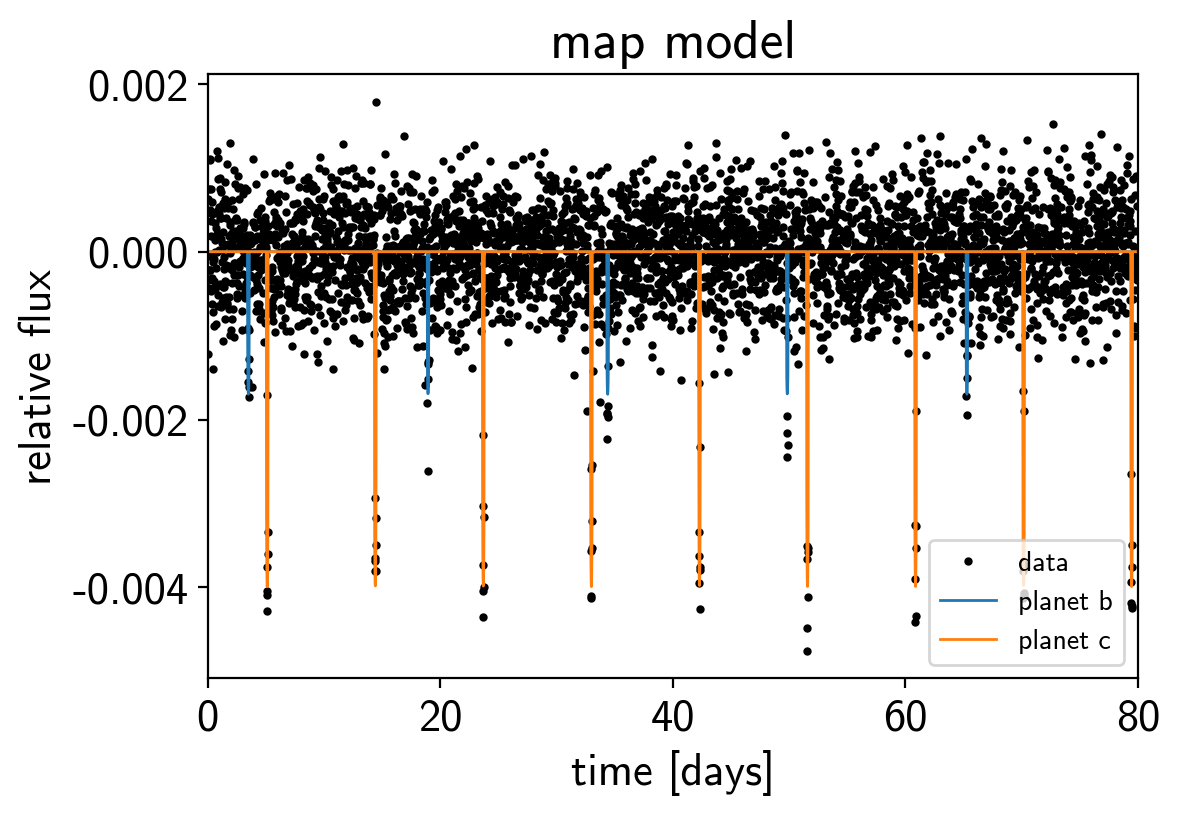

In [6]:
plt.plot(t, y, ".k", ms=4, label="data")
for i, l in enumerate("bc"):
    plt.plot(t, map_soln["light_curves"][:, i], lw=1,
             label="planet {0}".format(l))
plt.xlim(t.min(), t.max())
plt.ylabel("relative flux")
plt.xlabel("time [days]")
plt.legend(fontsize=10)
plt.title("map model");

## Sampling

Now, let's sample from the posterior defined by this model.
As usual, there are strong covariances between some of the parameters so we'll use the :class:`exoplanet.PyMC3Sampler` to sample.

In [7]:
np.random.seed(42)
sampler = xo.PyMC3Sampler(window=100, finish=200)
with model:
    burnin = sampler.tune(tune=2500, start=map_soln, step_kwargs=dict(target_accept=0.9))
    trace = sampler.sample(draws=3000)

Sampling 4 chains:   0%|          | 0/308 [00:00<?, ?draws/s]

Sampling 4 chains:   7%|▋         | 21/308 [00:00<00:02, 136.88draws/s]

Sampling 4 chains:   8%|▊         | 26/308 [00:00<00:03, 74.67draws/s] 

Sampling 4 chains:  10%|▉         | 30/308 [00:00<00:05, 53.83draws/s]

Sampling 4 chains:  11%|█         | 34/308 [00:00<00:06, 45.07draws/s]

Sampling 4 chains:  12%|█▏        | 38/308 [00:00<00:06, 40.50draws/s]

Sampling 4 chains:  14%|█▎        | 42/308 [00:00<00:07, 37.77draws/s]

Sampling 4 chains:  15%|█▍        | 46/308 [00:00<00:07, 35.22draws/s]

Sampling 4 chains:  16%|█▌        | 50/308 [00:01<00:07, 34.46draws/s]

Sampling 4 chains:  18%|█▊        | 54/308 [00:01<00:07, 33.83draws/s]

Sampling 4 chains:  19%|█▉        | 58/308 [00:01<00:07, 33.96draws/s]

Sampling 4 chains:  20%|██        | 62/308 [00:01<00:07, 33.69draws/s]

Sampling 4 chains:  21%|██▏       | 66/308 [00:01<00:07, 33.51draws/s]

Sampling 4 chains:  23%|██▎       | 70/308 [00:01<00:07, 33.37draws/s]

Sampling 4 chains:  24%|██▍       | 74/308 [00:01<00:07, 33.29draws/s]

Sampling 4 chains:  25%|██▌       | 78/308 [00:01<00:06, 33.24draws/s]

Sampling 4 chains:  27%|██▋       | 82/308 [00:02<00:06, 33.19draws/s]

Sampling 4 chains:  28%|██▊       | 86/308 [00:02<00:06, 33.17draws/s]

Sampling 4 chains:  29%|██▉       | 90/308 [00:02<00:06, 33.14draws/s]

Sampling 4 chains:  31%|███       | 94/308 [00:02<00:06, 34.67draws/s]

Sampling 4 chains:  32%|███▏      | 99/308 [00:02<00:05, 35.65draws/s]

Sampling 4 chains:  33%|███▎      | 103/308 [00:02<00:05, 34.22draws/s]

Sampling 4 chains:  35%|███▍      | 107/308 [00:02<00:06, 33.25draws/s]

Sampling 4 chains:  36%|███▌      | 111/308 [00:02<00:06, 32.62draws/s]

Sampling 4 chains:  37%|███▋      | 115/308 [00:02<00:05, 32.20draws/s]

Sampling 4 chains:  39%|███▊      | 119/308 [00:03<00:05, 31.90draws/s]

Sampling 4 chains:  40%|███▉      | 123/308 [00:03<00:05, 31.69draws/s]

Sampling 4 chains:  42%|████▏     | 128/308 [00:03<00:05, 33.18draws/s]

Sampling 4 chains:  43%|████▎     | 133/308 [00:03<00:05, 34.76draws/s]

Sampling 4 chains:  44%|████▍     | 137/308 [00:03<00:05, 33.64draws/s]

Sampling 4 chains:  46%|████▌     | 141/308 [00:03<00:05, 32.88draws/s]

Sampling 4 chains:  47%|████▋     | 145/308 [00:03<00:04, 32.66draws/s]

Sampling 4 chains:  48%|████▊     | 149/308 [00:04<00:04, 32.66draws/s]

Sampling 4 chains:  50%|████▉     | 153/308 [00:04<00:04, 32.50draws/s]

Sampling 4 chains:  51%|█████     | 157/308 [00:04<00:04, 32.53draws/s]

Sampling 4 chains:  52%|█████▏    | 161/308 [00:04<00:04, 32.55draws/s]

Sampling 4 chains:  54%|█████▎    | 165/308 [00:04<00:04, 32.58draws/s]

Sampling 4 chains:  55%|█████▍    | 169/308 [00:04<00:04, 32.58draws/s]

Sampling 4 chains:  56%|█████▌    | 173/308 [00:04<00:04, 32.59draws/s]

Sampling 4 chains:  57%|█████▋    | 177/308 [00:04<00:04, 32.60draws/s]

Sampling 4 chains:  59%|█████▉    | 181/308 [00:04<00:03, 32.62draws/s]

Sampling 4 chains:  60%|██████    | 185/308 [00:05<00:03, 32.13draws/s]

Sampling 4 chains:  61%|██████▏   | 189/308 [00:05<00:03, 32.18draws/s]

Sampling 4 chains:  63%|██████▎   | 193/308 [00:05<00:03, 32.23draws/s]

Sampling 4 chains:  64%|██████▍   | 197/308 [00:05<00:03, 32.28draws/s]

Sampling 4 chains:  65%|██████▌   | 201/308 [00:05<00:03, 32.31draws/s]

Sampling 4 chains:  67%|██████▋   | 205/308 [00:05<00:03, 32.54draws/s]

Sampling 4 chains:  68%|██████▊   | 209/308 [00:05<00:03, 32.72draws/s]

Sampling 4 chains:  69%|██████▉   | 213/308 [00:05<00:02, 32.86draws/s]

Sampling 4 chains:  70%|███████   | 217/308 [00:06<00:02, 32.89draws/s]

Sampling 4 chains:  72%|███████▏  | 221/308 [00:06<00:02, 32.96draws/s]

Sampling 4 chains:  73%|███████▎  | 225/308 [00:06<00:02, 33.02draws/s]

Sampling 4 chains:  75%|███████▍  | 230/308 [00:06<00:02, 35.15draws/s]

Sampling 4 chains:  76%|███████▌  | 234/308 [00:06<00:02, 34.51draws/s]

Sampling 4 chains:  77%|███████▋  | 238/308 [00:06<00:02, 33.71draws/s]

Sampling 4 chains:  79%|███████▊  | 242/308 [00:06<00:02, 32.98draws/s]

Sampling 4 chains:  80%|███████▉  | 246/308 [00:06<00:01, 32.48draws/s]

Sampling 4 chains:  81%|████████  | 250/308 [00:07<00:01, 32.12draws/s]

Sampling 4 chains:  82%|████████▏ | 254/308 [00:07<00:01, 31.89draws/s]

Sampling 4 chains:  84%|████████▍ | 258/308 [00:07<00:01, 31.84draws/s]

Sampling 4 chains:  85%|████████▌ | 262/308 [00:07<00:01, 32.06draws/s]

Sampling 4 chains:  86%|████████▋ | 266/308 [00:07<00:01, 32.23draws/s]

Sampling 4 chains:  88%|████████▊ | 270/308 [00:07<00:01, 32.02draws/s]

Sampling 4 chains:  89%|████████▉ | 274/308 [00:07<00:01, 32.18draws/s]

Sampling 4 chains:  90%|█████████ | 278/308 [00:07<00:00, 32.32draws/s]

Sampling 4 chains:  92%|█████████▏| 282/308 [00:08<00:00, 32.38draws/s]

Sampling 4 chains:  93%|█████████▎| 286/308 [00:08<00:00, 32.43draws/s]

Sampling 4 chains:  94%|█████████▍| 290/308 [00:08<00:00, 32.46draws/s]

Sampling 4 chains:  95%|█████████▌| 294/308 [00:08<00:00, 32.50draws/s]

Sampling 4 chains:  97%|█████████▋| 298/308 [00:08<00:00, 32.52draws/s]

Sampling 4 chains:  98%|█████████▊| 302/308 [00:08<00:00, 30.71draws/s]

Sampling 4 chains:  99%|█████████▉| 306/308 [00:09<00:00, 18.71draws/s]

Sampling 4 chains: 100%|██████████| 308/308 [00:09<00:00, 32.73draws/s]

Sampling 4 chains:   0%|          | 0/408 [00:00<?, ?draws/s]

Sampling 4 chains:   5%|▌         | 21/408 [00:00<00:02, 129.77draws/s]

Sampling 4 chains:   6%|▌         | 25/408 [00:00<00:05, 66.81draws/s] 

Sampling 4 chains:   7%|▋         | 29/408 [00:00<00:07, 48.41draws/s]

Sampling 4 chains:   8%|▊         | 34/408 [00:00<00:08, 44.82draws/s]

Sampling 4 chains:   9%|▉         | 38/408 [00:00<00:09, 40.07draws/s]

Sampling 4 chains:  11%|█         | 43/408 [00:00<00:09, 40.03draws/s]

Sampling 4 chains:  12%|█▏        | 47/408 [00:00<00:09, 37.31draws/s]

Sampling 4 chains:  12%|█▎        | 51/408 [00:01<00:10, 35.41draws/s]

Sampling 4 chains:  14%|█▎        | 56/408 [00:01<00:09, 36.76draws/s]

Sampling 4 chains:  15%|█▍        | 60/408 [00:01<00:09, 35.30draws/s]

Sampling 4 chains:  16%|█▌        | 64/408 [00:01<00:10, 34.36draws/s]

Sampling 4 chains:  17%|█▋        | 70/408 [00:01<00:09, 37.37draws/s]

Sampling 4 chains:  18%|█▊        | 74/408 [00:01<00:09, 35.71draws/s]

Sampling 4 chains:  19%|█▉        | 79/408 [00:01<00:08, 37.01draws/s]

Sampling 4 chains:  20%|██        | 83/408 [00:01<00:09, 34.86draws/s]

Sampling 4 chains:  21%|██▏       | 87/408 [00:02<00:09, 34.07draws/s]

Sampling 4 chains:  23%|██▎       | 92/408 [00:02<00:08, 35.77draws/s]

Sampling 4 chains:  24%|██▎       | 96/408 [00:02<00:08, 34.67draws/s]

Sampling 4 chains:  25%|██▍       | 100/408 [00:02<00:08, 34.93draws/s]

Sampling 4 chains:  25%|██▌       | 104/408 [00:02<00:09, 33.61draws/s]

Sampling 4 chains:  26%|██▋       | 108/408 [00:02<00:09, 32.35draws/s]

Sampling 4 chains:  28%|██▊       | 113/408 [00:02<00:08, 34.41draws/s]

Sampling 4 chains:  29%|██▊       | 117/408 [00:02<00:08, 33.53draws/s]

Sampling 4 chains:  30%|███       | 123/408 [00:03<00:07, 36.82draws/s]

Sampling 4 chains:  31%|███▏      | 128/408 [00:03<00:07, 36.67draws/s]

Sampling 4 chains:  32%|███▏      | 132/408 [00:03<00:08, 34.42draws/s]

Sampling 4 chains:  33%|███▎      | 136/408 [00:03<00:08, 33.16draws/s]

Sampling 4 chains:  35%|███▍      | 141/408 [00:03<00:07, 35.03draws/s]

Sampling 4 chains:  36%|███▌      | 146/408 [00:03<00:07, 36.45draws/s]

Sampling 4 chains:  37%|███▋      | 152/408 [00:03<00:06, 39.36draws/s]

Sampling 4 chains:  38%|███▊      | 157/408 [00:03<00:06, 39.63draws/s]

Sampling 4 chains:  40%|███▉      | 162/408 [00:04<00:06, 39.54draws/s]

Sampling 4 chains:  41%|████      | 167/408 [00:04<00:06, 36.40draws/s]

Sampling 4 chains:  42%|████▏     | 171/408 [00:04<00:06, 34.59draws/s]

Sampling 4 chains:  43%|████▎     | 176/408 [00:04<00:06, 36.01draws/s]

Sampling 4 chains:  44%|████▍     | 181/408 [00:04<00:06, 37.29draws/s]

Sampling 4 chains:  45%|████▌     | 185/408 [00:04<00:06, 35.39draws/s]

Sampling 4 chains:  46%|████▋     | 189/408 [00:04<00:06, 34.46draws/s]

Sampling 4 chains:  47%|████▋     | 193/408 [00:04<00:06, 33.79draws/s]

Sampling 4 chains:  48%|████▊     | 197/408 [00:05<00:06, 33.39draws/s]

Sampling 4 chains:  49%|████▉     | 201/408 [00:05<00:06, 32.89draws/s]

Sampling 4 chains:  50%|█████     | 205/408 [00:05<00:06, 32.77draws/s]

Sampling 4 chains:  51%|█████     | 209/408 [00:05<00:06, 32.69draws/s]

Sampling 4 chains:  52%|█████▏    | 214/408 [00:05<00:05, 34.70draws/s]

Sampling 4 chains:  53%|█████▎    | 218/408 [00:05<00:05, 34.00draws/s]

Sampling 4 chains:  54%|█████▍    | 222/408 [00:05<00:05, 33.15draws/s]

Sampling 4 chains:  55%|█████▌    | 226/408 [00:05<00:05, 32.63draws/s]

Sampling 4 chains:  57%|█████▋    | 231/408 [00:06<00:05, 34.66draws/s]

Sampling 4 chains:  58%|█████▊    | 236/408 [00:06<00:04, 35.92draws/s]

Sampling 4 chains:  59%|█████▉    | 240/408 [00:06<00:04, 34.54draws/s]

Sampling 4 chains:  60%|█████▉    | 244/408 [00:06<00:04, 33.91draws/s]

Sampling 4 chains:  61%|██████    | 248/408 [00:06<00:04, 33.46draws/s]

Sampling 4 chains:  62%|██████▏   | 253/408 [00:06<00:04, 37.06draws/s]

Sampling 4 chains:  63%|██████▎   | 257/408 [00:06<00:04, 37.21draws/s]

Sampling 4 chains:  64%|██████▍   | 261/408 [00:06<00:04, 35.61draws/s]

Sampling 4 chains:  65%|██████▍   | 265/408 [00:07<00:04, 34.56draws/s]

Sampling 4 chains:  66%|██████▌   | 270/408 [00:07<00:03, 36.12draws/s]

Sampling 4 chains:  67%|██████▋   | 275/408 [00:07<00:03, 37.31draws/s]

Sampling 4 chains:  68%|██████▊   | 279/408 [00:07<00:03, 35.67draws/s]

Sampling 4 chains:  70%|██████▉   | 284/408 [00:07<00:03, 36.52draws/s]

Sampling 4 chains:  71%|███████   | 288/408 [00:07<00:03, 35.10draws/s]

Sampling 4 chains:  72%|███████▏  | 292/408 [00:07<00:03, 34.00draws/s]

Sampling 4 chains:  73%|███████▎  | 296/408 [00:07<00:03, 33.48draws/s]

Sampling 4 chains:  74%|███████▎  | 300/408 [00:08<00:03, 33.12draws/s]

Sampling 4 chains:  75%|███████▌  | 306/408 [00:08<00:02, 36.60draws/s]

Sampling 4 chains:  76%|███████▌  | 310/408 [00:08<00:02, 35.19draws/s]

Sampling 4 chains:  77%|███████▋  | 314/408 [00:08<00:02, 34.28draws/s]

Sampling 4 chains:  78%|███████▊  | 318/408 [00:08<00:02, 33.67draws/s]

Sampling 4 chains:  79%|███████▉  | 324/408 [00:08<00:02, 36.68draws/s]

Sampling 4 chains:  80%|████████  | 328/408 [00:08<00:02, 35.23draws/s]

Sampling 4 chains:  81%|████████▏ | 332/408 [00:08<00:02, 34.31draws/s]

Sampling 4 chains:  82%|████████▏ | 336/408 [00:09<00:02, 33.41draws/s]

Sampling 4 chains:  83%|████████▎ | 340/408 [00:09<00:02, 33.05draws/s]

Sampling 4 chains:  84%|████████▍ | 344/408 [00:09<00:01, 34.58draws/s]

Sampling 4 chains:  85%|████████▌ | 348/408 [00:09<00:01, 33.43draws/s]

Sampling 4 chains:  87%|████████▋ | 353/408 [00:09<00:01, 34.93draws/s]

Sampling 4 chains:  88%|████████▊ | 357/408 [00:09<00:01, 33.73draws/s]

Sampling 4 chains:  89%|████████▊ | 362/408 [00:09<00:01, 34.34draws/s]

Sampling 4 chains:  90%|████████▉ | 366/408 [00:09<00:01, 33.72draws/s]

Sampling 4 chains:  91%|█████████ | 371/408 [00:10<00:01, 35.48draws/s]

Sampling 4 chains:  92%|█████████▏| 375/408 [00:10<00:00, 34.48draws/s]

Sampling 4 chains:  93%|█████████▎| 379/408 [00:10<00:00, 33.81draws/s]

Sampling 4 chains:  94%|█████████▍| 383/408 [00:10<00:00, 33.35draws/s]

Sampling 4 chains:  95%|█████████▌| 388/408 [00:10<00:00, 35.20draws/s]

Sampling 4 chains:  96%|█████████▌| 392/408 [00:10<00:00, 34.23draws/s]

Sampling 4 chains:  97%|█████████▋| 396/408 [00:10<00:00, 30.12draws/s]

Sampling 4 chains:  98%|█████████▊| 400/408 [00:10<00:00, 29.91draws/s]

Sampling 4 chains:  99%|█████████▉| 404/408 [00:11<00:00, 23.44draws/s]

Sampling 4 chains: 100%|█████████▉| 407/408 [00:11<00:00, 17.87draws/s]

Sampling 4 chains: 100%|██████████| 408/408 [00:12<00:00, 33.91draws/s]

Sampling 4 chains:   0%|          | 0/808 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 1/808 [00:00<01:47,  7.50draws/s]

Sampling 4 chains:   1%|          | 10/808 [00:00<01:17, 10.24draws/s]

Sampling 4 chains:   2%|▏         | 14/808 [00:00<01:02, 12.68draws/s]

Sampling 4 chains:   2%|▏         | 19/808 [00:00<00:48, 16.14draws/s]

Sampling 4 chains:   3%|▎         | 23/808 [00:00<00:42, 18.65draws/s]

Sampling 4 chains:   3%|▎         | 28/808 [00:00<00:34, 22.83draws/s]

Sampling 4 chains:   4%|▍         | 32/808 [00:00<00:29, 26.03draws/s]

Sampling 4 chains:   5%|▍         | 37/808 [00:00<00:26, 29.36draws/s]

Sampling 4 chains:   5%|▌         | 41/808 [00:01<00:25, 29.74draws/s]

Sampling 4 chains:   6%|▌         | 45/808 [00:01<00:25, 30.22draws/s]

Sampling 4 chains:   6%|▋         | 52/808 [00:01<00:20, 36.12draws/s]

Sampling 4 chains:   7%|▋         | 57/808 [00:01<00:19, 39.29draws/s]

Sampling 4 chains:   8%|▊         | 62/808 [00:01<00:18, 40.79draws/s]

Sampling 4 chains:   8%|▊         | 68/808 [00:01<00:17, 42.75draws/s]

Sampling 4 chains:   9%|▉         | 73/808 [00:01<00:18, 39.92draws/s]

Sampling 4 chains:  10%|▉         | 78/808 [00:01<00:18, 39.03draws/s]

Sampling 4 chains:  10%|█         | 83/808 [00:02<00:18, 39.56draws/s]

Sampling 4 chains:  11%|█         | 88/808 [00:02<00:18, 38.49draws/s]

Sampling 4 chains:  12%|█▏        | 94/808 [00:02<00:18, 39.19draws/s]

Sampling 4 chains:  12%|█▏        | 100/808 [00:02<00:16, 42.97draws/s]

Sampling 4 chains:  13%|█▎        | 105/808 [00:02<00:16, 43.27draws/s]

Sampling 4 chains:  14%|█▎        | 110/808 [00:02<00:16, 42.21draws/s]

Sampling 4 chains:  14%|█▍        | 115/808 [00:02<00:16, 41.43draws/s]

Sampling 4 chains:  15%|█▍        | 120/808 [00:02<00:16, 41.46draws/s]

Sampling 4 chains:  15%|█▌        | 125/808 [00:03<00:17, 39.82draws/s]

Sampling 4 chains:  16%|█▌        | 130/808 [00:03<00:16, 41.19draws/s]

Sampling 4 chains:  17%|█▋        | 135/808 [00:03<00:16, 40.90draws/s]

Sampling 4 chains:  17%|█▋        | 140/808 [00:03<00:18, 36.20draws/s]

Sampling 4 chains:  18%|█▊        | 145/808 [00:03<00:17, 36.87draws/s]

Sampling 4 chains:  19%|█▊        | 150/808 [00:03<00:17, 37.67draws/s]

Sampling 4 chains:  19%|█▉        | 156/808 [00:03<00:17, 37.62draws/s]

Sampling 4 chains:  20%|█▉        | 161/808 [00:04<00:16, 38.29draws/s]

Sampling 4 chains:  20%|██        | 165/808 [00:04<00:17, 36.04draws/s]

Sampling 4 chains:  21%|██        | 170/808 [00:04<00:17, 37.10draws/s]

Sampling 4 chains:  22%|██▏       | 174/808 [00:04<00:17, 35.36draws/s]

Sampling 4 chains:  22%|██▏       | 180/808 [00:04<00:16, 38.48draws/s]

Sampling 4 chains:  23%|██▎       | 185/808 [00:04<00:16, 38.77draws/s]

Sampling 4 chains:  24%|██▎       | 191/808 [00:04<00:16, 37.75draws/s]

Sampling 4 chains:  24%|██▍       | 195/808 [00:04<00:16, 36.52draws/s]

Sampling 4 chains:  25%|██▍       | 201/808 [00:05<00:14, 40.84draws/s]

Sampling 4 chains:  26%|██▌       | 207/808 [00:05<00:13, 43.18draws/s]

Sampling 4 chains:  26%|██▋       | 214/808 [00:05<00:13, 43.78draws/s]

Sampling 4 chains:  27%|██▋       | 221/808 [00:05<00:12, 46.54draws/s]

Sampling 4 chains:  28%|██▊       | 227/808 [00:05<00:11, 49.03draws/s]

Sampling 4 chains:  29%|██▉       | 233/808 [00:05<00:12, 44.97draws/s]

Sampling 4 chains:  30%|██▉       | 239/808 [00:05<00:12, 45.30draws/s]

Sampling 4 chains:  30%|███       | 244/808 [00:05<00:12, 46.40draws/s]

Sampling 4 chains:  31%|███       | 249/808 [00:06<00:12, 44.34draws/s]

Sampling 4 chains:  31%|███▏      | 254/808 [00:06<00:13, 42.07draws/s]

Sampling 4 chains:  32%|███▏      | 259/808 [00:06<00:13, 41.13draws/s]

Sampling 4 chains:  33%|███▎      | 264/808 [00:06<00:14, 38.19draws/s]

Sampling 4 chains:  33%|███▎      | 268/808 [00:06<00:15, 35.71draws/s]

Sampling 4 chains:  34%|███▎      | 272/808 [00:06<00:15, 33.94draws/s]

Sampling 4 chains:  34%|███▍      | 276/808 [00:06<00:15, 34.19draws/s]

Sampling 4 chains:  35%|███▍      | 281/808 [00:07<00:14, 35.21draws/s]

Sampling 4 chains:  36%|███▌      | 288/808 [00:07<00:13, 38.71draws/s]

Sampling 4 chains:  36%|███▋      | 294/808 [00:07<00:13, 39.52draws/s]

Sampling 4 chains:  37%|███▋      | 299/808 [00:07<00:13, 37.86draws/s]

Sampling 4 chains:  38%|███▊      | 303/808 [00:07<00:14, 35.77draws/s]

Sampling 4 chains:  38%|███▊      | 309/808 [00:07<00:12, 40.43draws/s]

Sampling 4 chains:  39%|███▉      | 314/808 [00:07<00:12, 40.18draws/s]

Sampling 4 chains:  39%|███▉      | 319/808 [00:07<00:12, 39.94draws/s]

Sampling 4 chains:  40%|████      | 324/808 [00:08<00:12, 38.03draws/s]

Sampling 4 chains:  41%|████      | 331/808 [00:08<00:11, 41.92draws/s]

Sampling 4 chains:  42%|████▏     | 336/808 [00:08<00:12, 38.59draws/s]

Sampling 4 chains:  42%|████▏     | 341/808 [00:08<00:12, 38.88draws/s]

Sampling 4 chains:  43%|████▎     | 347/808 [00:08<00:11, 38.72draws/s]

Sampling 4 chains:  43%|████▎     | 351/808 [00:08<00:12, 36.28draws/s]

Sampling 4 chains:  44%|████▍     | 355/808 [00:08<00:12, 34.88draws/s]

Sampling 4 chains:  44%|████▍     | 359/808 [00:09<00:13, 33.95draws/s]

Sampling 4 chains:  45%|████▍     | 363/808 [00:09<00:13, 33.37draws/s]

Sampling 4 chains:  46%|████▌     | 369/808 [00:09<00:11, 37.76draws/s]

Sampling 4 chains:  46%|████▋     | 374/808 [00:09<00:10, 39.49draws/s]

Sampling 4 chains:  47%|████▋     | 379/808 [00:09<00:11, 38.42draws/s]

Sampling 4 chains:  47%|████▋     | 383/808 [00:09<00:11, 36.44draws/s]

Sampling 4 chains:  48%|████▊     | 389/808 [00:09<00:10, 40.91draws/s]

Sampling 4 chains:  49%|████▉     | 394/808 [00:09<00:10, 38.21draws/s]

Sampling 4 chains:  49%|████▉     | 399/808 [00:09<00:10, 39.27draws/s]

Sampling 4 chains:  50%|█████     | 404/808 [00:10<00:10, 39.45draws/s]

Sampling 4 chains:  51%|█████     | 409/808 [00:10<00:10, 38.49draws/s]

Sampling 4 chains:  51%|█████     | 413/808 [00:10<00:10, 36.24draws/s]

Sampling 4 chains:  52%|█████▏    | 418/808 [00:10<00:10, 36.88draws/s]

Sampling 4 chains:  53%|█████▎    | 426/808 [00:10<00:09, 41.73draws/s]

Sampling 4 chains:  53%|█████▎    | 432/808 [00:10<00:08, 42.28draws/s]

Sampling 4 chains:  54%|█████▍    | 437/808 [00:10<00:09, 38.65draws/s]

Sampling 4 chains:  55%|█████▌    | 446/808 [00:11<00:08, 43.70draws/s]

Sampling 4 chains:  56%|█████▌    | 454/808 [00:11<00:07, 48.86draws/s]

Sampling 4 chains:  57%|█████▋    | 460/808 [00:11<00:07, 48.07draws/s]

Sampling 4 chains:  58%|█████▊    | 466/808 [00:11<00:07, 46.56draws/s]

Sampling 4 chains:  58%|█████▊    | 471/808 [00:11<00:07, 46.53draws/s]

Sampling 4 chains:  59%|█████▉    | 476/808 [00:11<00:07, 43.53draws/s]

Sampling 4 chains:  60%|█████▉    | 481/808 [00:11<00:07, 44.54draws/s]

Sampling 4 chains:  60%|██████    | 486/808 [00:11<00:07, 41.78draws/s]

Sampling 4 chains:  61%|██████    | 493/808 [00:12<00:06, 45.27draws/s]

Sampling 4 chains:  62%|██████▏   | 500/808 [00:12<00:06, 50.20draws/s]

Sampling 4 chains:  63%|██████▎   | 506/808 [00:12<00:06, 48.76draws/s]

Sampling 4 chains:  63%|██████▎   | 512/808 [00:12<00:05, 51.16draws/s]

Sampling 4 chains:  64%|██████▍   | 518/808 [00:12<00:06, 45.03draws/s]

Sampling 4 chains:  65%|██████▌   | 526/808 [00:12<00:05, 49.18draws/s]

Sampling 4 chains:  66%|██████▌   | 532/808 [00:12<00:06, 41.38draws/s]

Sampling 4 chains:  67%|██████▋   | 538/808 [00:13<00:06, 43.14draws/s]

Sampling 4 chains:  67%|██████▋   | 543/808 [00:13<00:06, 42.18draws/s]

Sampling 4 chains:  68%|██████▊   | 548/808 [00:13<00:06, 41.60draws/s]

Sampling 4 chains:  68%|██████▊   | 553/808 [00:13<00:05, 43.50draws/s]

Sampling 4 chains:  69%|██████▉   | 558/808 [00:13<00:06, 40.17draws/s]

Sampling 4 chains:  70%|██████▉   | 563/808 [00:13<00:06, 40.17draws/s]

Sampling 4 chains:  70%|███████   | 569/808 [00:13<00:05, 39.92draws/s]

Sampling 4 chains:  71%|███████▏  | 577/808 [00:13<00:04, 46.97draws/s]

Sampling 4 chains:  72%|███████▏  | 583/808 [00:14<00:04, 46.22draws/s]

Sampling 4 chains:  73%|███████▎  | 590/808 [00:14<00:04, 48.82draws/s]

Sampling 4 chains:  74%|███████▍  | 596/808 [00:14<00:04, 43.30draws/s]

Sampling 4 chains:  75%|███████▍  | 602/808 [00:14<00:04, 46.65draws/s]

Sampling 4 chains:  75%|███████▌  | 610/808 [00:14<00:03, 52.80draws/s]

Sampling 4 chains:  76%|███████▌  | 616/808 [00:14<00:03, 48.38draws/s]

Sampling 4 chains:  77%|███████▋  | 622/808 [00:14<00:04, 44.04draws/s]

Sampling 4 chains:  78%|███████▊  | 627/808 [00:14<00:03, 45.57draws/s]

Sampling 4 chains:  78%|███████▊  | 632/808 [00:15<00:04, 41.05draws/s]

Sampling 4 chains:  79%|███████▉  | 637/808 [00:15<00:03, 42.89draws/s]

Sampling 4 chains:  79%|███████▉  | 642/808 [00:15<00:04, 40.21draws/s]

Sampling 4 chains:  80%|████████  | 647/808 [00:15<00:03, 41.80draws/s]

Sampling 4 chains:  81%|████████  | 652/808 [00:15<00:03, 42.02draws/s]

Sampling 4 chains:  81%|████████▏ | 657/808 [00:15<00:03, 41.38draws/s]

Sampling 4 chains:  82%|████████▏ | 662/808 [00:15<00:03, 41.25draws/s]

Sampling 4 chains:  83%|████████▎ | 667/808 [00:15<00:03, 39.09draws/s]

Sampling 4 chains:  83%|████████▎ | 673/808 [00:16<00:03, 42.07draws/s]

Sampling 4 chains:  84%|████████▍ | 678/808 [00:16<00:03, 41.39draws/s]

Sampling 4 chains:  85%|████████▍ | 683/808 [00:16<00:03, 39.57draws/s]

Sampling 4 chains:  85%|████████▌ | 688/808 [00:16<00:02, 41.01draws/s]

Sampling 4 chains:  86%|████████▌ | 693/808 [00:16<00:02, 40.69draws/s]

Sampling 4 chains:  86%|████████▋ | 698/808 [00:16<00:02, 39.04draws/s]

Sampling 4 chains:  87%|████████▋ | 702/808 [00:16<00:02, 37.14draws/s]

Sampling 4 chains:  88%|████████▊ | 707/808 [00:17<00:02, 36.27draws/s]

Sampling 4 chains:  88%|████████▊ | 711/808 [00:17<00:02, 37.17draws/s]

Sampling 4 chains:  89%|████████▊ | 716/808 [00:17<00:02, 37.48draws/s]

Sampling 4 chains:  89%|████████▉ | 721/808 [00:17<00:02, 40.52draws/s]

Sampling 4 chains:  90%|████████▉ | 726/808 [00:17<00:01, 41.67draws/s]

Sampling 4 chains:  90%|█████████ | 731/808 [00:17<00:01, 41.15draws/s]

Sampling 4 chains:  91%|█████████ | 736/808 [00:17<00:01, 39.45draws/s]

Sampling 4 chains:  92%|█████████▏| 741/808 [00:17<00:01, 41.07draws/s]

Sampling 4 chains:  92%|█████████▏| 747/808 [00:17<00:01, 41.50draws/s]

Sampling 4 chains:  93%|█████████▎| 755/808 [00:18<00:01, 42.70draws/s]

Sampling 4 chains:  94%|█████████▍| 763/808 [00:18<00:00, 47.96draws/s]

Sampling 4 chains:  95%|█████████▌| 769/808 [00:18<00:00, 47.85draws/s]

Sampling 4 chains:  96%|█████████▌| 774/808 [00:18<00:00, 42.36draws/s]

Sampling 4 chains:  96%|█████████▋| 779/808 [00:18<00:00, 41.03draws/s]

Sampling 4 chains:  97%|█████████▋| 784/808 [00:18<00:00, 36.16draws/s]

Sampling 4 chains:  98%|█████████▊| 789/808 [00:18<00:00, 37.12draws/s]

Sampling 4 chains:  98%|█████████▊| 793/808 [00:19<00:00, 37.29draws/s]

Sampling 4 chains:  99%|█████████▊| 797/808 [00:19<00:00, 32.64draws/s]

Sampling 4 chains:  99%|█████████▉| 801/808 [00:19<00:00, 31.69draws/s]

Sampling 4 chains: 100%|█████████▉| 806/808 [00:19<00:00, 34.96draws/s]

Sampling 4 chains: 100%|██████████| 808/808 [00:20<00:00, 40.15draws/s]

Sampling 4 chains:   0%|          | 0/1608 [00:00<?, ?draws/s]

Sampling 4 chains:   2%|▏         | 31/1608 [00:00<00:05, 308.57draws/s]

Sampling 4 chains:   4%|▍         | 67/1608 [00:00<00:04, 320.05draws/s]

Sampling 4 chains:   7%|▋         | 116/1608 [00:00<00:04, 355.72draws/s]

Sampling 4 chains:  10%|▉         | 156/1608 [00:00<00:03, 367.37draws/s]

Sampling 4 chains:  13%|█▎        | 205/1608 [00:00<00:03, 396.11draws/s]

Sampling 4 chains:  16%|█▌        | 253/1608 [00:00<00:03, 418.01draws/s]

Sampling 4 chains:  19%|█▊        | 301/1608 [00:00<00:03, 432.82draws/s]

Sampling 4 chains:  23%|██▎       | 363/1608 [00:00<00:02, 475.11draws/s]

Sampling 4 chains:  26%|██▌       | 411/1608 [00:00<00:02, 460.20draws/s]

Sampling 4 chains:  28%|██▊       | 458/1608 [00:01<00:02, 454.16draws/s]

Sampling 4 chains:  32%|███▏      | 509/1608 [00:01<00:02, 468.25draws/s]

Sampling 4 chains:  35%|███▌      | 564/1608 [00:01<00:02, 486.85draws/s]

Sampling 4 chains:  38%|███▊      | 614/1608 [00:01<00:02, 479.76draws/s]

Sampling 4 chains:  42%|████▏     | 669/1608 [00:01<00:01, 498.65draws/s]

Sampling 4 chains:  45%|████▍     | 723/1608 [00:01<00:01, 507.49draws/s]

Sampling 4 chains:  48%|████▊     | 775/1608 [00:01<00:01, 508.14draws/s]

Sampling 4 chains:  51%|█████▏    | 827/1608 [00:01<00:01, 497.79draws/s]

Sampling 4 chains:  55%|█████▌    | 889/1608 [00:01<00:01, 528.33draws/s]

Sampling 4 chains:  59%|█████▊    | 943/1608 [00:01<00:01, 523.80draws/s]

Sampling 4 chains:  62%|██████▏   | 999/1608 [00:02<00:01, 533.05draws/s]

Sampling 4 chains:  65%|██████▌   | 1053/1608 [00:02<00:01, 534.86draws/s]

Sampling 4 chains:  69%|██████▉   | 1107/1608 [00:02<00:00, 529.03draws/s]

Sampling 4 chains:  72%|███████▏  | 1165/1608 [00:02<00:00, 543.18draws/s]

Sampling 4 chains:  76%|███████▌  | 1225/1608 [00:02<00:00, 552.97draws/s]

Sampling 4 chains:  80%|███████▉  | 1281/1608 [00:02<00:00, 532.84draws/s]

Sampling 4 chains:  83%|████████▎ | 1335/1608 [00:02<00:00, 524.58draws/s]

Sampling 4 chains:  86%|████████▋ | 1388/1608 [00:02<00:00, 504.96draws/s]

Sampling 4 chains:  90%|████████▉ | 1441/1608 [00:02<00:00, 511.61draws/s]

Sampling 4 chains:  93%|█████████▎| 1499/1608 [00:03<00:00, 530.03draws/s]

Sampling 4 chains:  97%|█████████▋| 1553/1608 [00:03<00:00, 524.03draws/s]

Sampling 4 chains: 100%|█████████▉| 1606/1608 [00:03<00:00, 325.19draws/s]

Sampling 4 chains: 100%|██████████| 1608/1608 [00:03<00:00, 463.28draws/s]

Sampling 4 chains:   0%|          | 0/6908 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 28/6908 [00:00<00:24, 276.28draws/s]

Sampling 4 chains:   1%|          | 66/6908 [00:00<00:23, 296.49draws/s]

Sampling 4 chains:   2%|▏         | 106/6908 [00:00<00:21, 321.30draws/s]

Sampling 4 chains:   2%|▏         | 141/6908 [00:00<00:20, 326.33draws/s]

Sampling 4 chains:   3%|▎         | 173/6908 [00:00<00:20, 322.19draws/s]

Sampling 4 chains:   3%|▎         | 208/6908 [00:00<00:20, 328.57draws/s]

Sampling 4 chains:   4%|▎         | 253/6908 [00:00<00:18, 356.18draws/s]

Sampling 4 chains:   4%|▍         | 291/6908 [00:00<00:18, 361.57draws/s]

Sampling 4 chains:   5%|▍         | 338/6908 [00:00<00:17, 385.02draws/s]

Sampling 4 chains:   5%|▌         | 377/6908 [00:01<00:17, 378.27draws/s]

Sampling 4 chains:   6%|▌         | 430/6908 [00:01<00:15, 413.45draws/s]

Sampling 4 chains:   7%|▋         | 473/6908 [00:01<00:16, 395.20draws/s]

Sampling 4 chains:   8%|▊         | 524/6908 [00:01<00:15, 423.59draws/s]

Sampling 4 chains:   8%|▊         | 570/6908 [00:01<00:14, 432.68draws/s]

Sampling 4 chains:   9%|▉         | 618/6908 [00:01<00:14, 444.88draws/s]

Sampling 4 chains:  10%|▉         | 664/6908 [00:01<00:14, 426.23draws/s]

Sampling 4 chains:  10%|█         | 713/6908 [00:01<00:13, 442.56draws/s]

Sampling 4 chains:  11%|█         | 762/6908 [00:01<00:13, 454.60draws/s]

Sampling 4 chains:  12%|█▏        | 817/6908 [00:01<00:12, 478.06draws/s]

Sampling 4 chains:  13%|█▎        | 867/6908 [00:02<00:12, 471.06draws/s]

Sampling 4 chains:  13%|█▎        | 917/6908 [00:02<00:12, 477.50draws/s]

Sampling 4 chains:  14%|█▍        | 966/6908 [00:02<00:12, 475.46draws/s]

Sampling 4 chains:  15%|█▍        | 1014/6908 [00:02<00:12, 476.62draws/s]

Sampling 4 chains:  15%|█▌        | 1062/6908 [00:02<00:12, 465.75draws/s]

Sampling 4 chains:  16%|█▌        | 1109/6908 [00:02<00:12, 457.04draws/s]

Sampling 4 chains:  17%|█▋        | 1158/6908 [00:02<00:12, 465.43draws/s]

Sampling 4 chains:  17%|█▋        | 1208/6908 [00:02<00:12, 474.79draws/s]

Sampling 4 chains:  18%|█▊        | 1256/6908 [00:02<00:12, 469.84draws/s]

Sampling 4 chains:  19%|█▉        | 1307/6908 [00:03<00:11, 479.81draws/s]

Sampling 4 chains:  20%|█▉        | 1358/6908 [00:03<00:11, 481.58draws/s]

Sampling 4 chains:  20%|██        | 1407/6908 [00:03<00:11, 474.67draws/s]

Sampling 4 chains:  21%|██        | 1455/6908 [00:03<00:11, 467.18draws/s]

Sampling 4 chains:  22%|██▏       | 1504/6908 [00:03<00:11, 472.62draws/s]

Sampling 4 chains:  22%|██▏       | 1554/6908 [00:03<00:11, 478.67draws/s]

Sampling 4 chains:  23%|██▎       | 1602/6908 [00:03<00:11, 469.41draws/s]

Sampling 4 chains:  24%|██▍       | 1654/6908 [00:03<00:10, 481.69draws/s]

Sampling 4 chains:  25%|██▍       | 1705/6908 [00:03<00:10, 488.79draws/s]

Sampling 4 chains:  25%|██▌       | 1755/6908 [00:03<00:10, 491.39draws/s]

Sampling 4 chains:  26%|██▌       | 1806/6908 [00:04<00:10, 496.61draws/s]

Sampling 4 chains:  27%|██▋       | 1856/6908 [00:04<00:10, 479.98draws/s]

Sampling 4 chains:  28%|██▊       | 1905/6908 [00:04<00:10, 477.71draws/s]

Sampling 4 chains:  28%|██▊       | 1954/6908 [00:04<00:10, 481.04draws/s]

Sampling 4 chains:  29%|██▉       | 2005/6908 [00:04<00:10, 488.05draws/s]

Sampling 4 chains:  30%|██▉       | 2056/6908 [00:04<00:09, 491.07draws/s]

Sampling 4 chains:  30%|███       | 2106/6908 [00:04<00:09, 489.84draws/s]

Sampling 4 chains:  31%|███       | 2156/6908 [00:04<00:09, 484.24draws/s]

Sampling 4 chains:  32%|███▏      | 2205/6908 [00:04<00:09, 481.88draws/s]

Sampling 4 chains:  33%|███▎      | 2254/6908 [00:04<00:09, 471.09draws/s]

Sampling 4 chains:  33%|███▎      | 2305/6908 [00:05<00:09, 481.40draws/s]

Sampling 4 chains:  34%|███▍      | 2354/6908 [00:05<00:09, 478.02draws/s]

Sampling 4 chains:  35%|███▍      | 2402/6908 [00:05<00:09, 475.29draws/s]

Sampling 4 chains:  35%|███▌      | 2451/6908 [00:05<00:09, 479.32draws/s]

Sampling 4 chains:  36%|███▌      | 2502/6908 [00:05<00:09, 486.49draws/s]

Sampling 4 chains:  37%|███▋      | 2555/6908 [00:05<00:08, 495.69draws/s]

Sampling 4 chains:  38%|███▊      | 2606/6908 [00:05<00:08, 499.54draws/s]

Sampling 4 chains:  38%|███▊      | 2657/6908 [00:05<00:08, 501.62draws/s]

Sampling 4 chains:  39%|███▉      | 2708/6908 [00:05<00:08, 493.81draws/s]

Sampling 4 chains:  40%|███▉      | 2758/6908 [00:06<00:08, 487.21draws/s]

Sampling 4 chains:  41%|████      | 2807/6908 [00:06<00:08, 473.98draws/s]

Sampling 4 chains:  41%|████▏     | 2855/6908 [00:06<00:08, 464.05draws/s]

Sampling 4 chains:  42%|████▏     | 2907/6908 [00:06<00:08, 479.01draws/s]

Sampling 4 chains:  43%|████▎     | 2956/6908 [00:06<00:08, 469.70draws/s]

Sampling 4 chains:  44%|████▎     | 3011/6908 [00:06<00:07, 490.20draws/s]

Sampling 4 chains:  44%|████▍     | 3066/6908 [00:06<00:07, 506.08draws/s]

Sampling 4 chains:  45%|████▌     | 3121/6908 [00:06<00:07, 517.55draws/s]

Sampling 4 chains:  46%|████▌     | 3174/6908 [00:06<00:07, 519.56draws/s]

Sampling 4 chains:  47%|████▋     | 3227/6908 [00:06<00:07, 521.19draws/s]

Sampling 4 chains:  47%|████▋     | 3280/6908 [00:07<00:07, 514.01draws/s]

Sampling 4 chains:  48%|████▊     | 3333/6908 [00:07<00:06, 518.17draws/s]

Sampling 4 chains:  49%|████▉     | 3386/6908 [00:07<00:06, 521.00draws/s]

Sampling 4 chains:  50%|████▉     | 3439/6908 [00:07<00:06, 520.25draws/s]

Sampling 4 chains:  51%|█████     | 3492/6908 [00:07<00:06, 523.01draws/s]

Sampling 4 chains:  51%|█████▏    | 3545/6908 [00:07<00:06, 515.00draws/s]

Sampling 4 chains:  52%|█████▏    | 3599/6908 [00:07<00:06, 520.71draws/s]

Sampling 4 chains:  53%|█████▎    | 3652/6908 [00:07<00:06, 518.45draws/s]

Sampling 4 chains:  54%|█████▎    | 3704/6908 [00:07<00:06, 516.60draws/s]

Sampling 4 chains:  54%|█████▍    | 3756/6908 [00:07<00:06, 509.74draws/s]

Sampling 4 chains:  55%|█████▌    | 3808/6908 [00:08<00:06, 498.14draws/s]

Sampling 4 chains:  56%|█████▌    | 3859/6908 [00:08<00:06, 501.32draws/s]

Sampling 4 chains:  57%|█████▋    | 3914/6908 [00:08<00:05, 514.66draws/s]

Sampling 4 chains:  57%|█████▋    | 3966/6908 [00:08<00:05, 511.24draws/s]

Sampling 4 chains:  58%|█████▊    | 4018/6908 [00:08<00:05, 508.29draws/s]

Sampling 4 chains:  59%|█████▉    | 4069/6908 [00:08<00:05, 502.07draws/s]

Sampling 4 chains:  60%|█████▉    | 4121/6908 [00:08<00:05, 506.13draws/s]

Sampling 4 chains:  60%|██████    | 4172/6908 [00:08<00:05, 492.01draws/s]

Sampling 4 chains:  61%|██████    | 4222/6908 [00:08<00:05, 484.13draws/s]

Sampling 4 chains:  62%|██████▏   | 4271/6908 [00:09<00:05, 482.65draws/s]

Sampling 4 chains:  63%|██████▎   | 4320/6908 [00:09<00:05, 476.15draws/s]

Sampling 4 chains:  63%|██████▎   | 4375/6908 [00:09<00:05, 493.31draws/s]

Sampling 4 chains:  64%|██████▍   | 4426/6908 [00:09<00:05, 494.67draws/s]

Sampling 4 chains:  65%|██████▍   | 4480/6908 [00:09<00:04, 506.89draws/s]

Sampling 4 chains:  66%|██████▌   | 4535/6908 [00:09<00:04, 517.92draws/s]

Sampling 4 chains:  66%|██████▋   | 4587/6908 [00:09<00:04, 506.57draws/s]

Sampling 4 chains:  67%|██████▋   | 4640/6908 [00:09<00:04, 513.11draws/s]

Sampling 4 chains:  68%|██████▊   | 4694/6908 [00:09<00:04, 519.15draws/s]

Sampling 4 chains:  69%|██████▊   | 4747/6908 [00:09<00:04, 515.12draws/s]

Sampling 4 chains:  69%|██████▉   | 4799/6908 [00:10<00:04, 499.40draws/s]

Sampling 4 chains:  70%|███████   | 4850/6908 [00:10<00:04, 499.47draws/s]

Sampling 4 chains:  71%|███████   | 4901/6908 [00:10<00:04, 498.74draws/s]

Sampling 4 chains:  72%|███████▏  | 4951/6908 [00:10<00:03, 498.77draws/s]

Sampling 4 chains:  72%|███████▏  | 5001/6908 [00:10<00:03, 489.51draws/s]

Sampling 4 chains:  73%|███████▎  | 5051/6908 [00:10<00:03, 484.78draws/s]

Sampling 4 chains:  74%|███████▍  | 5102/6908 [00:10<00:03, 491.25draws/s]

Sampling 4 chains:  75%|███████▍  | 5154/6908 [00:10<00:03, 496.36draws/s]

Sampling 4 chains:  75%|███████▌  | 5205/6908 [00:10<00:03, 499.71draws/s]

Sampling 4 chains:  76%|███████▌  | 5256/6908 [00:10<00:03, 501.65draws/s]

Sampling 4 chains:  77%|███████▋  | 5307/6908 [00:11<00:03, 486.69draws/s]

Sampling 4 chains:  78%|███████▊  | 5356/6908 [00:11<00:03, 476.17draws/s]

Sampling 4 chains:  78%|███████▊  | 5404/6908 [00:11<00:03, 465.66draws/s]

Sampling 4 chains:  79%|███████▉  | 5457/6908 [00:11<00:03, 481.62draws/s]

Sampling 4 chains:  80%|███████▉  | 5507/6908 [00:11<00:02, 486.48draws/s]

Sampling 4 chains:  80%|████████  | 5558/6908 [00:11<00:02, 492.58draws/s]

Sampling 4 chains:  81%|████████  | 5608/6908 [00:11<00:02, 491.45draws/s]

Sampling 4 chains:  82%|████████▏ | 5658/6908 [00:11<00:02, 479.62draws/s]

Sampling 4 chains:  83%|████████▎ | 5711/6908 [00:11<00:02, 490.53draws/s]

Sampling 4 chains:  83%|████████▎ | 5764/6908 [00:12<00:02, 500.29draws/s]

Sampling 4 chains:  84%|████████▍ | 5816/6908 [00:12<00:02, 499.98draws/s]

Sampling 4 chains:  85%|████████▍ | 5868/6908 [00:12<00:02, 505.36draws/s]

Sampling 4 chains:  86%|████████▌ | 5925/6908 [00:12<00:01, 522.13draws/s]

Sampling 4 chains:  87%|████████▋ | 5978/6908 [00:12<00:01, 517.53draws/s]

Sampling 4 chains:  87%|████████▋ | 6031/6908 [00:12<00:01, 516.78draws/s]

Sampling 4 chains:  88%|████████▊ | 6083/6908 [00:12<00:01, 509.11draws/s]

Sampling 4 chains:  89%|████████▉ | 6135/6908 [00:12<00:01, 504.63draws/s]

Sampling 4 chains:  90%|████████▉ | 6186/6908 [00:12<00:01, 496.19draws/s]

Sampling 4 chains:  90%|█████████ | 6236/6908 [00:12<00:01, 478.87draws/s]

Sampling 4 chains:  91%|█████████ | 6287/6908 [00:13<00:01, 486.07draws/s]

Sampling 4 chains:  92%|█████████▏| 6336/6908 [00:13<00:01, 482.39draws/s]

Sampling 4 chains:  92%|█████████▏| 6388/6908 [00:13<00:01, 492.08draws/s]

Sampling 4 chains:  93%|█████████▎| 6438/6908 [00:13<00:00, 487.62draws/s]

Sampling 4 chains:  94%|█████████▍| 6493/6908 [00:13<00:00, 501.62draws/s]

Sampling 4 chains:  95%|█████████▍| 6544/6908 [00:13<00:00, 495.79draws/s]

Sampling 4 chains:  95%|█████████▌| 6594/6908 [00:13<00:00, 492.28draws/s]

Sampling 4 chains:  96%|█████████▌| 6645/6908 [00:13<00:00, 496.08draws/s]

Sampling 4 chains:  97%|█████████▋| 6697/6908 [00:13<00:00, 500.44draws/s]

Sampling 4 chains:  98%|█████████▊| 6748/6908 [00:13<00:00, 502.76draws/s]

Sampling 4 chains:  98%|█████████▊| 6801/6908 [00:14<00:00, 506.08draws/s]

Sampling 4 chains:  99%|█████████▉| 6852/6908 [00:14<00:00, 455.54draws/s]

Sampling 4 chains: 100%|█████████▉| 6899/6908 [00:14<00:00, 434.04draws/s]

Sampling 4 chains: 100%|██████████| 6908/6908 [00:14<00:00, 479.99draws/s]

Sampling 4 chains:   0%|          | 0/808 [00:00<?, ?draws/s]

Sampling 4 chains:   4%|▎         | 29/808 [00:00<00:02, 278.92draws/s]

Sampling 4 chains:   8%|▊         | 61/808 [00:00<00:02, 289.04draws/s]

Sampling 4 chains:  11%|█▏        | 91/808 [00:00<00:02, 290.22draws/s]

Sampling 4 chains:  15%|█▌        | 124/808 [00:00<00:02, 293.39draws/s]

Sampling 4 chains:  20%|██        | 162/808 [00:00<00:02, 313.53draws/s]

Sampling 4 chains:  25%|██▍       | 201/808 [00:00<00:01, 331.99draws/s]

Sampling 4 chains:  30%|██▉       | 241/808 [00:00<00:01, 347.17draws/s]

Sampling 4 chains:  34%|███▍      | 276/808 [00:00<00:01, 344.79draws/s]

Sampling 4 chains:  39%|███▉      | 316/808 [00:00<00:01, 357.51draws/s]

Sampling 4 chains:  45%|████▍     | 362/808 [00:01<00:01, 382.06draws/s]

Sampling 4 chains:  51%|█████     | 409/808 [00:01<00:00, 404.01draws/s]

Sampling 4 chains:  56%|█████▌    | 453/808 [00:01<00:00, 412.95draws/s]

Sampling 4 chains:  62%|██████▏   | 503/808 [00:01<00:00, 432.64draws/s]

Sampling 4 chains:  68%|██████▊   | 549/808 [00:01<00:00, 438.72draws/s]

Sampling 4 chains:  74%|███████▍  | 601/808 [00:01<00:00, 459.22draws/s]

Sampling 4 chains:  81%|████████  | 653/808 [00:01<00:00, 475.09draws/s]

Sampling 4 chains:  87%|████████▋ | 701/808 [00:01<00:00, 457.68draws/s]

Sampling 4 chains:  93%|█████████▎| 748/808 [00:01<00:00, 461.27draws/s]

Sampling 4 chains:  98%|█████████▊| 795/808 [00:02<00:00, 276.87draws/s]

Sampling 4 chains: 100%|██████████| 808/808 [00:02<00:00, 348.95draws/s]

Multiprocess sampling (4 chains in 4 jobs)


NUTS: [rb, u, logP, t0, mean]


Sampling 4 chains:   0%|          | 0/12000 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 39/12000 [00:00<00:30, 388.53draws/s]

Sampling 4 chains:   1%|          | 88/12000 [00:00<00:28, 413.27draws/s]

Sampling 4 chains:   1%|          | 140/12000 [00:00<00:26, 439.81draws/s]

Sampling 4 chains:   2%|▏         | 191/12000 [00:00<00:25, 458.62draws/s]

Sampling 4 chains:   2%|▏         | 240/12000 [00:00<00:25, 466.58draws/s]

Sampling 4 chains:   2%|▏         | 293/12000 [00:00<00:24, 480.47draws/s]

Sampling 4 chains:   3%|▎         | 343/12000 [00:00<00:24, 485.61draws/s]

Sampling 4 chains:   3%|▎         | 395/12000 [00:00<00:23, 494.93draws/s]

Sampling 4 chains:   4%|▎         | 444/12000 [00:00<00:23, 489.88draws/s]

Sampling 4 chains:   4%|▍         | 497/12000 [00:01<00:23, 497.07draws/s]

Sampling 4 chains:   5%|▍         | 547/12000 [00:01<00:23, 497.30draws/s]

Sampling 4 chains:   5%|▍         | 597/12000 [00:01<00:22, 496.25draws/s]

Sampling 4 chains:   5%|▌         | 648/12000 [00:01<00:22, 499.85draws/s]

Sampling 4 chains:   6%|▌         | 700/12000 [00:01<00:22, 504.78draws/s]

Sampling 4 chains:   6%|▋         | 751/12000 [00:01<00:22, 492.46draws/s]

Sampling 4 chains:   7%|▋         | 801/12000 [00:01<00:23, 484.29draws/s]

Sampling 4 chains:   7%|▋         | 850/12000 [00:01<00:23, 481.24draws/s]

Sampling 4 chains:   8%|▊         | 901/12000 [00:01<00:22, 487.78draws/s]

Sampling 4 chains:   8%|▊         | 953/12000 [00:01<00:22, 494.42draws/s]

Sampling 4 chains:   8%|▊         | 1003/12000 [00:02<00:22, 494.75draws/s]

Sampling 4 chains:   9%|▉         | 1054/12000 [00:02<00:21, 497.64draws/s]

Sampling 4 chains:   9%|▉         | 1104/12000 [00:02<00:22, 493.13draws/s]

Sampling 4 chains:  10%|▉         | 1156/12000 [00:02<00:21, 495.52draws/s]

Sampling 4 chains:  10%|█         | 1206/12000 [00:02<00:21, 490.89draws/s]

Sampling 4 chains:  10%|█         | 1256/12000 [00:02<00:21, 493.05draws/s]

Sampling 4 chains:  11%|█         | 1308/12000 [00:02<00:21, 499.59draws/s]

Sampling 4 chains:  11%|█▏        | 1358/12000 [00:02<00:22, 483.68draws/s]

Sampling 4 chains:  12%|█▏        | 1408/12000 [00:02<00:21, 482.22draws/s]

Sampling 4 chains:  12%|█▏        | 1457/12000 [00:02<00:21, 479.91draws/s]

Sampling 4 chains:  13%|█▎        | 1506/12000 [00:03<00:21, 480.68draws/s]

Sampling 4 chains:  13%|█▎        | 1555/12000 [00:03<00:21, 479.31draws/s]

Sampling 4 chains:  13%|█▎        | 1607/12000 [00:03<00:21, 488.25draws/s]

Sampling 4 chains:  14%|█▍        | 1656/12000 [00:03<00:21, 480.74draws/s]

Sampling 4 chains:  14%|█▍        | 1707/12000 [00:03<00:21, 484.07draws/s]

Sampling 4 chains:  15%|█▍        | 1758/12000 [00:03<00:20, 488.91draws/s]

Sampling 4 chains:  15%|█▌        | 1811/12000 [00:03<00:20, 499.74draws/s]

Sampling 4 chains:  16%|█▌        | 1862/12000 [00:03<00:20, 490.26draws/s]

Sampling 4 chains:  16%|█▌        | 1912/12000 [00:03<00:20, 492.26draws/s]

Sampling 4 chains:  16%|█▋        | 1962/12000 [00:04<00:20, 486.67draws/s]

Sampling 4 chains:  17%|█▋        | 2012/12000 [00:04<00:20, 490.00draws/s]

Sampling 4 chains:  17%|█▋        | 2062/12000 [00:04<00:20, 492.30draws/s]

Sampling 4 chains:  18%|█▊        | 2112/12000 [00:04<00:20, 488.53draws/s]

Sampling 4 chains:  18%|█▊        | 2161/12000 [00:04<00:20, 482.60draws/s]

Sampling 4 chains:  18%|█▊        | 2210/12000 [00:04<00:20, 483.73draws/s]

Sampling 4 chains:  19%|█▉        | 2263/12000 [00:04<00:19, 496.24draws/s]

Sampling 4 chains:  19%|█▉        | 2314/12000 [00:04<00:19, 499.02draws/s]

Sampling 4 chains:  20%|█▉        | 2364/12000 [00:04<00:19, 494.51draws/s]

Sampling 4 chains:  20%|██        | 2414/12000 [00:04<00:19, 494.07draws/s]

Sampling 4 chains:  21%|██        | 2464/12000 [00:05<00:19, 492.08draws/s]

Sampling 4 chains:  21%|██        | 2514/12000 [00:05<00:19, 489.15draws/s]

Sampling 4 chains:  21%|██▏       | 2563/12000 [00:05<00:19, 478.54draws/s]

Sampling 4 chains:  22%|██▏       | 2614/12000 [00:05<00:19, 486.38draws/s]

Sampling 4 chains:  22%|██▏       | 2664/12000 [00:05<00:19, 488.18draws/s]

Sampling 4 chains:  23%|██▎       | 2714/12000 [00:05<00:19, 488.59draws/s]

Sampling 4 chains:  23%|██▎       | 2763/12000 [00:05<00:19, 485.07draws/s]

Sampling 4 chains:  23%|██▎       | 2812/12000 [00:05<00:18, 485.08draws/s]

Sampling 4 chains:  24%|██▍       | 2862/12000 [00:05<00:18, 488.57draws/s]

Sampling 4 chains:  24%|██▍       | 2912/12000 [00:05<00:18, 491.52draws/s]

Sampling 4 chains:  25%|██▍       | 2963/12000 [00:06<00:18, 496.57draws/s]

Sampling 4 chains:  25%|██▌       | 3013/12000 [00:06<00:18, 488.94draws/s]

Sampling 4 chains:  26%|██▌       | 3062/12000 [00:06<00:18, 484.89draws/s]

Sampling 4 chains:  26%|██▌       | 3113/12000 [00:06<00:18, 491.04draws/s]

Sampling 4 chains:  26%|██▋       | 3163/12000 [00:06<00:18, 487.80draws/s]

Sampling 4 chains:  27%|██▋       | 3215/12000 [00:06<00:17, 495.50draws/s]

Sampling 4 chains:  27%|██▋       | 3265/12000 [00:06<00:17, 492.52draws/s]

Sampling 4 chains:  28%|██▊       | 3315/12000 [00:06<00:17, 487.40draws/s]

Sampling 4 chains:  28%|██▊       | 3364/12000 [00:06<00:17, 482.27draws/s]

Sampling 4 chains:  28%|██▊       | 3413/12000 [00:06<00:17, 482.92draws/s]

Sampling 4 chains:  29%|██▉       | 3465/12000 [00:07<00:17, 490.35draws/s]

Sampling 4 chains:  29%|██▉       | 3516/12000 [00:07<00:17, 492.63draws/s]

Sampling 4 chains:  30%|██▉       | 3567/12000 [00:07<00:16, 497.33draws/s]

Sampling 4 chains:  30%|███       | 3618/12000 [00:07<00:16, 493.50draws/s]

Sampling 4 chains:  31%|███       | 3672/12000 [00:07<00:16, 500.20draws/s]

Sampling 4 chains:  31%|███       | 3723/12000 [00:07<00:16, 493.39draws/s]

Sampling 4 chains:  31%|███▏      | 3773/12000 [00:07<00:16, 489.56draws/s]

Sampling 4 chains:  32%|███▏      | 3824/12000 [00:07<00:16, 494.79draws/s]

Sampling 4 chains:  32%|███▏      | 3876/12000 [00:07<00:16, 500.40draws/s]

Sampling 4 chains:  33%|███▎      | 3929/12000 [00:08<00:15, 505.28draws/s]

Sampling 4 chains:  33%|███▎      | 3980/12000 [00:08<00:15, 505.85draws/s]

Sampling 4 chains:  34%|███▎      | 4032/12000 [00:08<00:15, 504.87draws/s]

Sampling 4 chains:  34%|███▍      | 4084/12000 [00:08<00:15, 507.61draws/s]

Sampling 4 chains:  34%|███▍      | 4136/12000 [00:08<00:15, 509.01draws/s]

Sampling 4 chains:  35%|███▍      | 4187/12000 [00:08<00:15, 508.05draws/s]

Sampling 4 chains:  35%|███▌      | 4238/12000 [00:08<00:15, 503.32draws/s]

Sampling 4 chains:  36%|███▌      | 4290/12000 [00:08<00:15, 506.36draws/s]

Sampling 4 chains:  36%|███▌      | 4341/12000 [00:08<00:15, 499.41draws/s]

Sampling 4 chains:  37%|███▋      | 4395/12000 [00:08<00:14, 509.58draws/s]

Sampling 4 chains:  37%|███▋      | 4447/12000 [00:09<00:14, 510.15draws/s]

Sampling 4 chains:  37%|███▋      | 4499/12000 [00:09<00:15, 493.24draws/s]

Sampling 4 chains:  38%|███▊      | 4549/12000 [00:09<00:15, 492.19draws/s]

Sampling 4 chains:  38%|███▊      | 4599/12000 [00:09<00:15, 492.77draws/s]

Sampling 4 chains:  39%|███▊      | 4649/12000 [00:09<00:15, 489.69draws/s]

Sampling 4 chains:  39%|███▉      | 4701/12000 [00:09<00:14, 496.89draws/s]

Sampling 4 chains:  40%|███▉      | 4753/12000 [00:09<00:14, 499.02draws/s]

Sampling 4 chains:  40%|████      | 4806/12000 [00:09<00:14, 506.46draws/s]

Sampling 4 chains:  40%|████      | 4857/12000 [00:09<00:14, 497.12draws/s]

Sampling 4 chains:  41%|████      | 4909/12000 [00:09<00:14, 503.49draws/s]

Sampling 4 chains:  41%|████▏     | 4960/12000 [00:10<00:14, 500.91draws/s]

Sampling 4 chains:  42%|████▏     | 5011/12000 [00:10<00:13, 501.87draws/s]

Sampling 4 chains:  42%|████▏     | 5063/12000 [00:10<00:13, 499.91draws/s]

Sampling 4 chains:  43%|████▎     | 5114/12000 [00:10<00:13, 502.38draws/s]

Sampling 4 chains:  43%|████▎     | 5165/12000 [00:10<00:13, 496.73draws/s]

Sampling 4 chains:  43%|████▎     | 5217/12000 [00:10<00:13, 501.05draws/s]

Sampling 4 chains:  44%|████▍     | 5268/12000 [00:10<00:13, 492.27draws/s]

Sampling 4 chains:  44%|████▍     | 5318/12000 [00:10<00:13, 493.55draws/s]

Sampling 4 chains:  45%|████▍     | 5368/12000 [00:10<00:13, 492.11draws/s]

Sampling 4 chains:  45%|████▌     | 5418/12000 [00:10<00:13, 488.25draws/s]

Sampling 4 chains:  46%|████▌     | 5467/12000 [00:11<00:13, 476.25draws/s]

Sampling 4 chains:  46%|████▌     | 5515/12000 [00:11<00:13, 471.16draws/s]

Sampling 4 chains:  46%|████▋     | 5564/12000 [00:11<00:13, 474.59draws/s]

Sampling 4 chains:  47%|████▋     | 5612/12000 [00:11<00:13, 474.88draws/s]

Sampling 4 chains:  47%|████▋     | 5662/12000 [00:11<00:13, 480.51draws/s]

Sampling 4 chains:  48%|████▊     | 5712/12000 [00:11<00:13, 482.49draws/s]

Sampling 4 chains:  48%|████▊     | 5763/12000 [00:11<00:12, 489.54draws/s]

Sampling 4 chains:  48%|████▊     | 5813/12000 [00:11<00:12, 489.73draws/s]

Sampling 4 chains:  49%|████▉     | 5864/12000 [00:11<00:12, 494.23draws/s]

Sampling 4 chains:  49%|████▉     | 5918/12000 [00:12<00:12, 501.83draws/s]

Sampling 4 chains:  50%|████▉     | 5969/12000 [00:12<00:12, 499.15draws/s]

Sampling 4 chains:  50%|█████     | 6019/12000 [00:12<00:12, 494.05draws/s]

Sampling 4 chains:  51%|█████     | 6071/12000 [00:12<00:11, 499.32draws/s]

Sampling 4 chains:  51%|█████     | 6121/12000 [00:12<00:11, 490.21draws/s]

Sampling 4 chains:  51%|█████▏    | 6171/12000 [00:12<00:12, 483.01draws/s]

Sampling 4 chains:  52%|█████▏    | 6223/12000 [00:12<00:11, 493.23draws/s]

Sampling 4 chains:  52%|█████▏    | 6276/12000 [00:12<00:11, 497.93draws/s]

Sampling 4 chains:  53%|█████▎    | 6326/12000 [00:12<00:11, 493.19draws/s]

Sampling 4 chains:  53%|█████▎    | 6377/12000 [00:12<00:11, 495.32draws/s]

Sampling 4 chains:  54%|█████▎    | 6427/12000 [00:13<00:11, 485.06draws/s]

Sampling 4 chains:  54%|█████▍    | 6478/12000 [00:13<00:11, 487.39draws/s]

Sampling 4 chains:  54%|█████▍    | 6529/12000 [00:13<00:11, 492.59draws/s]

Sampling 4 chains:  55%|█████▍    | 6580/12000 [00:13<00:10, 497.62draws/s]

Sampling 4 chains:  55%|█████▌    | 6630/12000 [00:13<00:10, 496.18draws/s]

Sampling 4 chains:  56%|█████▌    | 6680/12000 [00:13<00:10, 491.12draws/s]

Sampling 4 chains:  56%|█████▌    | 6730/12000 [00:13<00:10, 486.30draws/s]

Sampling 4 chains:  56%|█████▋    | 6780/12000 [00:13<00:10, 489.72draws/s]

Sampling 4 chains:  57%|█████▋    | 6833/12000 [00:13<00:10, 499.57draws/s]

Sampling 4 chains:  57%|█████▋    | 6885/12000 [00:13<00:10, 503.01draws/s]

Sampling 4 chains:  58%|█████▊    | 6936/12000 [00:14<00:10, 489.50draws/s]

Sampling 4 chains:  58%|█████▊    | 6987/12000 [00:14<00:10, 495.31draws/s]

Sampling 4 chains:  59%|█████▊    | 7037/12000 [00:14<00:10, 488.81draws/s]

Sampling 4 chains:  59%|█████▉    | 7089/12000 [00:14<00:09, 495.82draws/s]

Sampling 4 chains:  59%|█████▉    | 7139/12000 [00:14<00:09, 493.34draws/s]

Sampling 4 chains:  60%|█████▉    | 7189/12000 [00:14<00:09, 493.30draws/s]

Sampling 4 chains:  60%|██████    | 7239/12000 [00:14<00:09, 493.20draws/s]

Sampling 4 chains:  61%|██████    | 7290/12000 [00:14<00:09, 496.35draws/s]

Sampling 4 chains:  61%|██████    | 7341/12000 [00:14<00:09, 497.44draws/s]

Sampling 4 chains:  62%|██████▏   | 7391/12000 [00:14<00:09, 493.83draws/s]

Sampling 4 chains:  62%|██████▏   | 7444/12000 [00:15<00:09, 503.62draws/s]

Sampling 4 chains:  62%|██████▏   | 7497/12000 [00:15<00:08, 509.12draws/s]

Sampling 4 chains:  63%|██████▎   | 7548/12000 [00:15<00:08, 509.11draws/s]

Sampling 4 chains:  63%|██████▎   | 7599/12000 [00:15<00:08, 501.41draws/s]

Sampling 4 chains:  64%|██████▍   | 7650/12000 [00:15<00:08, 496.74draws/s]

Sampling 4 chains:  64%|██████▍   | 7700/12000 [00:15<00:08, 490.15draws/s]

Sampling 4 chains:  65%|██████▍   | 7751/12000 [00:15<00:08, 494.70draws/s]

Sampling 4 chains:  65%|██████▌   | 7803/12000 [00:15<00:08, 497.62draws/s]

Sampling 4 chains:  65%|██████▌   | 7853/12000 [00:15<00:08, 487.92draws/s]

Sampling 4 chains:  66%|██████▌   | 7904/12000 [00:16<00:08, 492.92draws/s]

Sampling 4 chains:  66%|██████▋   | 7957/12000 [00:16<00:08, 502.02draws/s]

Sampling 4 chains:  67%|██████▋   | 8008/12000 [00:16<00:08, 494.92draws/s]

Sampling 4 chains:  67%|██████▋   | 8059/12000 [00:16<00:07, 495.76draws/s]

Sampling 4 chains:  68%|██████▊   | 8109/12000 [00:16<00:07, 493.00draws/s]

Sampling 4 chains:  68%|██████▊   | 8161/12000 [00:16<00:07, 500.72draws/s]

Sampling 4 chains:  68%|██████▊   | 8212/12000 [00:16<00:07, 494.84draws/s]

Sampling 4 chains:  69%|██████▉   | 8262/12000 [00:16<00:07, 485.86draws/s]

Sampling 4 chains:  69%|██████▉   | 8311/12000 [00:16<00:07, 483.61draws/s]

Sampling 4 chains:  70%|██████▉   | 8363/12000 [00:16<00:07, 493.70draws/s]

Sampling 4 chains:  70%|███████   | 8416/12000 [00:17<00:07, 500.92draws/s]

Sampling 4 chains:  71%|███████   | 8467/12000 [00:17<00:07, 500.15draws/s]

Sampling 4 chains:  71%|███████   | 8520/12000 [00:17<00:06, 508.52draws/s]

Sampling 4 chains:  71%|███████▏  | 8571/12000 [00:17<00:06, 502.01draws/s]

Sampling 4 chains:  72%|███████▏  | 8622/12000 [00:17<00:06, 502.46draws/s]

Sampling 4 chains:  72%|███████▏  | 8675/12000 [00:17<00:06, 508.78draws/s]

Sampling 4 chains:  73%|███████▎  | 8726/12000 [00:17<00:06, 506.92draws/s]

Sampling 4 chains:  73%|███████▎  | 8777/12000 [00:17<00:06, 504.46draws/s]

Sampling 4 chains:  74%|███████▎  | 8828/12000 [00:17<00:06, 497.30draws/s]

Sampling 4 chains:  74%|███████▍  | 8880/12000 [00:17<00:06, 501.84draws/s]

Sampling 4 chains:  74%|███████▍  | 8931/12000 [00:18<00:06, 491.12draws/s]

Sampling 4 chains:  75%|███████▍  | 8981/12000 [00:18<00:06, 489.87draws/s]

Sampling 4 chains:  75%|███████▌  | 9031/12000 [00:18<00:06, 491.46draws/s]

Sampling 4 chains:  76%|███████▌  | 9084/12000 [00:18<00:05, 499.99draws/s]

Sampling 4 chains:  76%|███████▌  | 9136/12000 [00:18<00:05, 504.94draws/s]

Sampling 4 chains:  77%|███████▋  | 9187/12000 [00:18<00:05, 505.05draws/s]

Sampling 4 chains:  77%|███████▋  | 9239/12000 [00:18<00:05, 508.08draws/s]

Sampling 4 chains:  77%|███████▋  | 9290/12000 [00:18<00:05, 495.91draws/s]

Sampling 4 chains:  78%|███████▊  | 9340/12000 [00:18<00:05, 493.13draws/s]

Sampling 4 chains:  78%|███████▊  | 9392/12000 [00:19<00:05, 497.91draws/s]

Sampling 4 chains:  79%|███████▊  | 9442/12000 [00:19<00:05, 498.13draws/s]

Sampling 4 chains:  79%|███████▉  | 9493/12000 [00:19<00:05, 500.51draws/s]

Sampling 4 chains:  80%|███████▉  | 9545/12000 [00:19<00:04, 501.10draws/s]

Sampling 4 chains:  80%|███████▉  | 9597/12000 [00:19<00:04, 503.35draws/s]

Sampling 4 chains:  80%|████████  | 9648/12000 [00:19<00:04, 488.33draws/s]

Sampling 4 chains:  81%|████████  | 9699/12000 [00:19<00:04, 493.82draws/s]

Sampling 4 chains:  81%|████████▏ | 9750/12000 [00:19<00:04, 497.33draws/s]

Sampling 4 chains:  82%|████████▏ | 9801/12000 [00:19<00:04, 499.59draws/s]

Sampling 4 chains:  82%|████████▏ | 9852/12000 [00:19<00:04, 495.97draws/s]

Sampling 4 chains:  83%|████████▎ | 9904/12000 [00:20<00:04, 502.04draws/s]

Sampling 4 chains:  83%|████████▎ | 9955/12000 [00:20<00:04, 501.75draws/s]

Sampling 4 chains:  83%|████████▎ | 10006/12000 [00:20<00:03, 502.87draws/s]

Sampling 4 chains:  84%|████████▍ | 10057/12000 [00:20<00:03, 497.79draws/s]

Sampling 4 chains:  84%|████████▍ | 10107/12000 [00:20<00:03, 496.86draws/s]

Sampling 4 chains:  85%|████████▍ | 10159/12000 [00:20<00:03, 499.30draws/s]

Sampling 4 chains:  85%|████████▌ | 10211/12000 [00:20<00:03, 501.33draws/s]

Sampling 4 chains:  86%|████████▌ | 10263/12000 [00:20<00:03, 504.86draws/s]

Sampling 4 chains:  86%|████████▌ | 10314/12000 [00:20<00:03, 504.65draws/s]

Sampling 4 chains:  86%|████████▋ | 10366/12000 [00:20<00:03, 505.39draws/s]

Sampling 4 chains:  87%|████████▋ | 10417/12000 [00:21<00:03, 505.36draws/s]

Sampling 4 chains:  87%|████████▋ | 10469/12000 [00:21<00:03, 505.46draws/s]

Sampling 4 chains:  88%|████████▊ | 10520/12000 [00:21<00:02, 500.83draws/s]

Sampling 4 chains:  88%|████████▊ | 10571/12000 [00:21<00:02, 499.64draws/s]

Sampling 4 chains:  89%|████████▊ | 10621/12000 [00:21<00:02, 496.37draws/s]

Sampling 4 chains:  89%|████████▉ | 10673/12000 [00:21<00:02, 501.25draws/s]

Sampling 4 chains:  89%|████████▉ | 10724/12000 [00:21<00:02, 498.42draws/s]

Sampling 4 chains:  90%|████████▉ | 10774/12000 [00:21<00:02, 496.49draws/s]

Sampling 4 chains:  90%|█████████ | 10824/12000 [00:21<00:02, 494.37draws/s]

Sampling 4 chains:  91%|█████████ | 10876/12000 [00:21<00:02, 499.55draws/s]

Sampling 4 chains:  91%|█████████ | 10929/12000 [00:22<00:02, 503.34draws/s]

Sampling 4 chains:  92%|█████████▏| 10980/12000 [00:22<00:02, 501.13draws/s]

Sampling 4 chains:  92%|█████████▏| 11031/12000 [00:22<00:01, 503.67draws/s]

Sampling 4 chains:  92%|█████████▏| 11082/12000 [00:22<00:01, 501.08draws/s]

Sampling 4 chains:  93%|█████████▎| 11133/12000 [00:22<00:01, 498.99draws/s]

Sampling 4 chains:  93%|█████████▎| 11183/12000 [00:22<00:01, 495.90draws/s]

Sampling 4 chains:  94%|█████████▎| 11235/12000 [00:22<00:01, 499.62draws/s]

Sampling 4 chains:  94%|█████████▍| 11286/12000 [00:22<00:01, 498.55draws/s]

Sampling 4 chains:  94%|█████████▍| 11337/12000 [00:22<00:01, 499.13draws/s]

Sampling 4 chains:  95%|█████████▍| 11387/12000 [00:23<00:01, 495.84draws/s]

Sampling 4 chains:  95%|█████████▌| 11437/12000 [00:23<00:01, 489.39draws/s]

Sampling 4 chains:  96%|█████████▌| 11486/12000 [00:23<00:01, 487.11draws/s]

Sampling 4 chains:  96%|█████████▌| 11537/12000 [00:23<00:00, 491.49draws/s]

Sampling 4 chains:  97%|█████████▋| 11587/12000 [00:23<00:00, 488.90draws/s]

Sampling 4 chains:  97%|█████████▋| 11638/12000 [00:23<00:00, 494.25draws/s]

Sampling 4 chains:  97%|█████████▋| 11688/12000 [00:23<00:00, 495.17draws/s]

Sampling 4 chains:  98%|█████████▊| 11739/12000 [00:23<00:00, 499.42draws/s]

Sampling 4 chains:  98%|█████████▊| 11790/12000 [00:23<00:00, 499.49draws/s]

Sampling 4 chains:  99%|█████████▊| 11840/12000 [00:23<00:00, 494.68draws/s]

Sampling 4 chains:  99%|█████████▉| 11890/12000 [00:24<00:00, 391.72draws/s]

Sampling 4 chains:  99%|█████████▉| 11933/12000 [00:24<00:00, 298.23draws/s]

Sampling 4 chains: 100%|█████████▉| 11969/12000 [00:24<00:00, 215.68draws/s]

Sampling 4 chains: 100%|█████████▉| 11998/12000 [00:24<00:00, 170.45draws/s]

Sampling 4 chains: 100%|██████████| 12000/12000 [00:24<00:00, 481.89draws/s]

After sampling, it's important that we assess convergence.
We can do that using the `pymc3.summary` function:

In [8]:
pm.summary(trace, varnames=["period", "t0", "r", "b", "u", "mean"])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
period__0,15.447914,0.002321,3.659947e-05,15.443122,15.452090,4385.443009,1.000574
period__1,9.292474,0.000301,2.808500e-06,9.291887,9.293050,12151.835330,0.999905
t0__0,3.503112,0.005837,9.350475e-05,3.492809,3.515157,4438.396882,1.000357
t0__1,5.121289,0.001370,1.149626e-05,5.118693,5.124023,13671.770308,0.999898
r__0,0.039526,0.001599,2.164871e-05,0.036400,0.042555,5932.885111,1.000028
r__1,0.058462,0.001054,1.516423e-05,0.056437,0.060415,5619.543688,1.000414
b__0,0.668522,0.047575,8.550631e-04,0.566165,0.738892,3357.794852,1.000184
b__1,0.402511,0.038414,5.352225e-04,0.324421,0.467398,5436.914504,1.000321
u__0,0.369271,0.206921,2.480988e-03,0.000376,0.727056,8685.453309,1.000082
u__1,0.283749,0.340357,4.995744e-03,-0.321040,0.871783,5649.580001,1.000259


That looks pretty good!
Fitting this without *exoplanet* would have taken a lot more patience.

Now we can also look at the [corner plot](https://corner.readthedocs.io) of some of that parameters of interest:

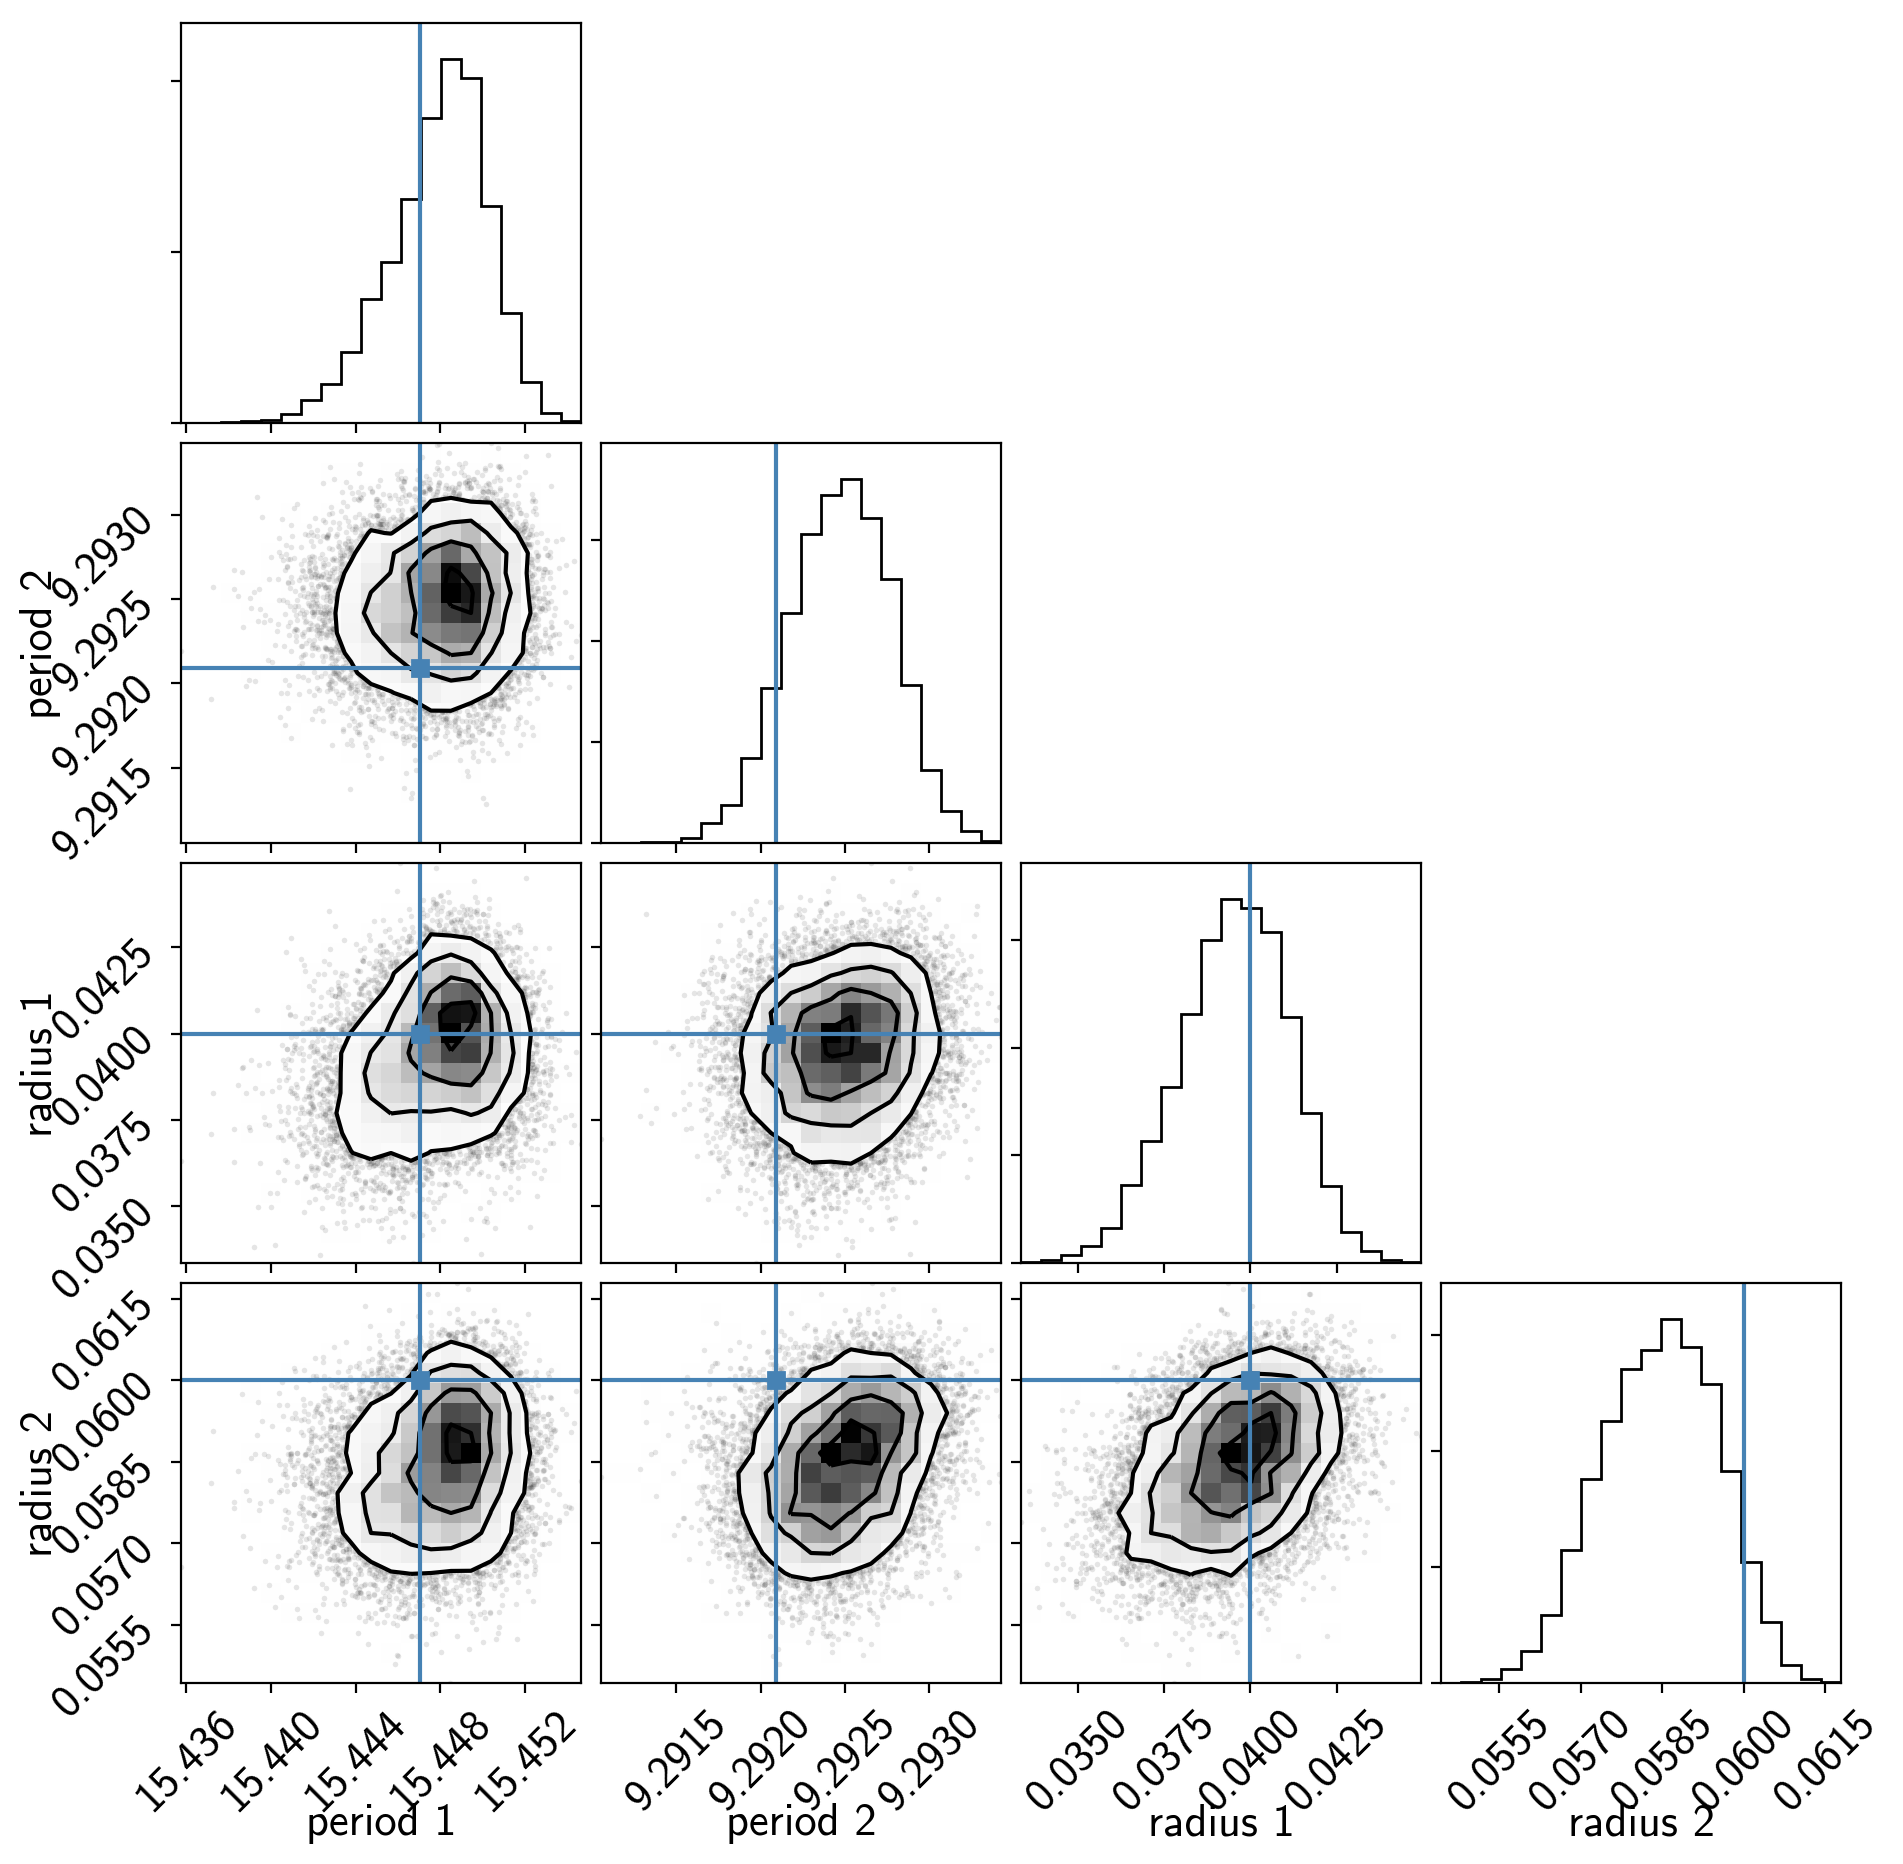

In [9]:
import corner
samples = pm.trace_to_dataframe(trace, varnames=["period", "r"])
truth = np.concatenate(xo.eval_in_model([period, r], model.test_point, model=model))
corner.corner(samples, truths=truth, labels=["period 1", "period 2", "radius 1", "radius 2"]);

## Phase plots

Like in the radial velocity tutorial (:ref:`rv`), we can make plots of the model predictions for each planet.

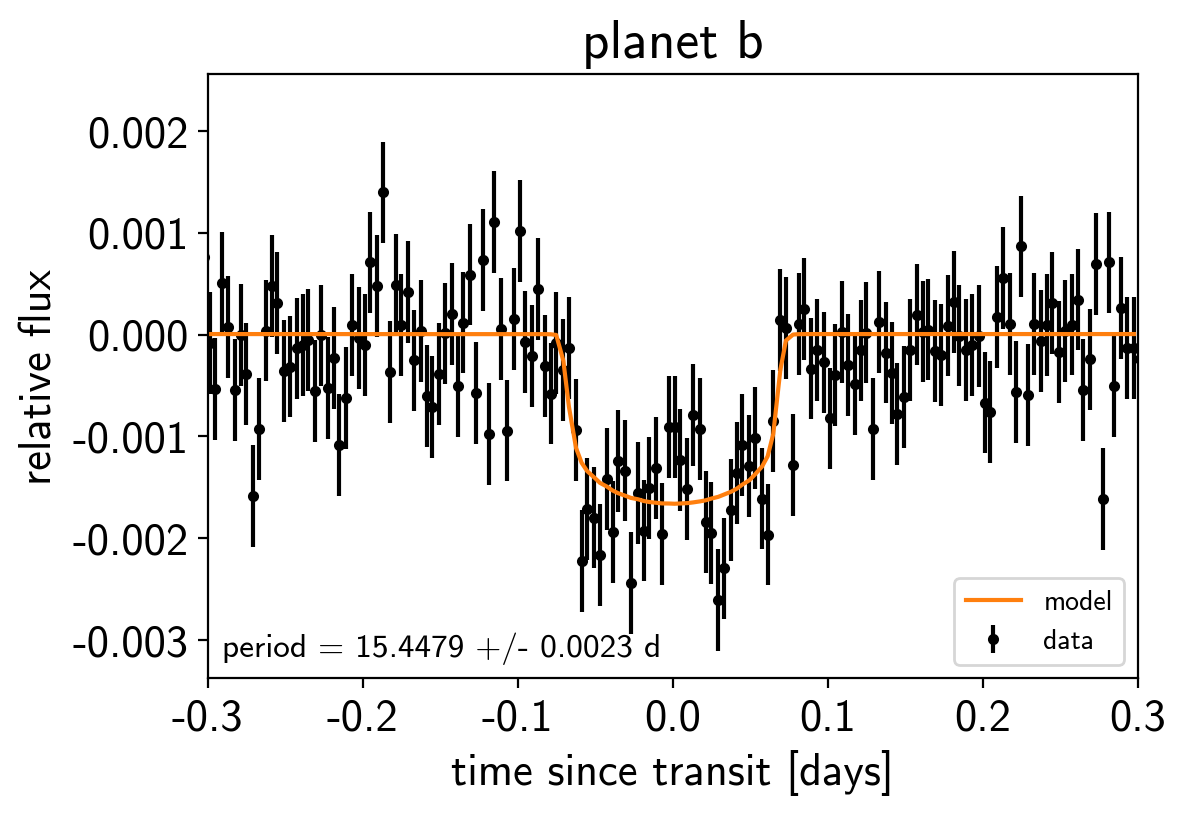

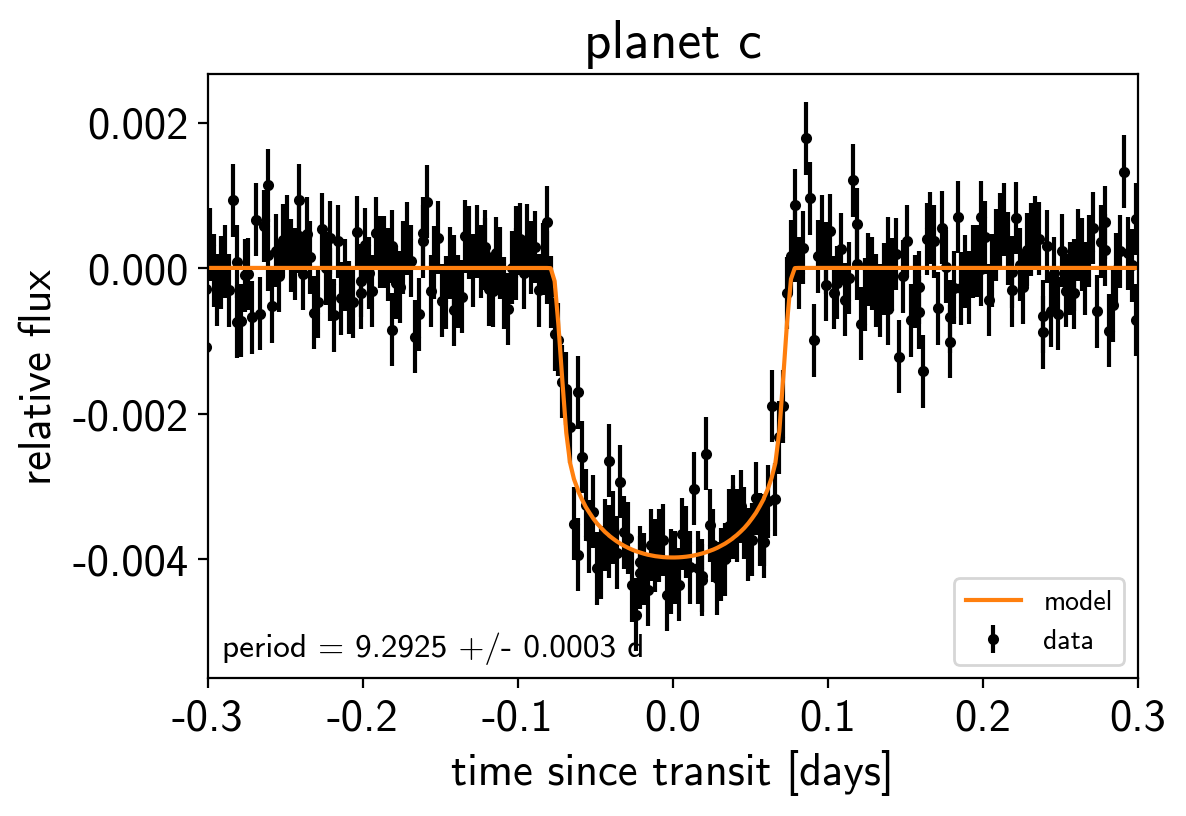

In [10]:
for n, letter in enumerate("bc"):
    plt.figure()

    # Get the posterior median orbital parameters
    p = np.median(trace["period"][:, n])
    t0 = np.median(trace["t0"][:, n])
    
    # Compute the median of posterior estimate of the contribution from
    # the other planet. Then we can remove this from the data to plot
    # just the planet we care about.
    other = np.median(trace["light_curves"][:, :, (n + 1) % 2], axis=0)

    # Plot the folded data
    x_fold = (t - t0 + 0.5*p) % p - 0.5*p
    plt.errorbar(x_fold, y - other, yerr=yerr, fmt=".k", label="data",
                 zorder=-1000)
    
    # Plot the folded model
    inds = np.argsort(x_fold)
    inds = inds[np.abs(x_fold)[inds] < 0.3]
    pred = trace["light_curves"][:, inds, n] + trace["mean"][:, None]
    pred = np.median(pred, axis=0)
    plt.plot(x_fold[inds], pred, color="C1", label="model")
    
    # Annotate the plot with the planet's period
    txt = "period = {0:.4f} +/- {1:.4f} d".format(
        np.mean(trace["period"][:, n]), np.std(trace["period"][:, n]))
    plt.annotate(txt, (0, 0), xycoords="axes fraction",
                 xytext=(5, 5), textcoords="offset points", 
                 ha="left", va="bottom", fontsize=12)

    plt.legend(fontsize=10, loc=4)
    plt.xlim(-0.5*p, 0.5*p)
    plt.xlabel("time since transit [days]")
    plt.ylabel("relative flux")
    plt.title("planet {0}".format(letter));
    plt.xlim(-0.3, 0.3)

## Citations

As described in the :ref:`citation` tutorial, we can use :func:`exoplanet.citations.get_citations_for_model` to construct an acknowledgement and BibTeX listing that includes the relevant citations for this model.
This is especially important here because we have used quite a few model components that should be cited.

In [11]:
with model:
    txt, bib = xo.citations.get_citations_for_model()
print(txt)

This research made use of \textsf{exoplanet} \citep{exoplanet} and its
dependencies \citep{exoplanet:astropy13, exoplanet:astropy18,
exoplanet:espinoza18, exoplanet:exoplanet, exoplanet:kipping13,
exoplanet:luger18, exoplanet:pymc3, exoplanet:theano}.


In [12]:
print("\n".join(bib.splitlines()[:10]) + "\n...")


@misc{exoplanet:exoplanet,
  author = {Dan Foreman-Mackey and
            Geert Barentsen and
            Tom Barclay},
   title = {dfm/exoplanet: exoplanet v0.1.6},
   month = apr,
    year = 2019,
     doi = {10.5281/zenodo.2651251},
     url = {https://doi.org/10.5281/zenodo.2651251}
...
